# 优化算法
- 就是用来知道怎么调整参数才能高效、稳定的找到损失函数的最小或者较小值的数学方法（类似多元函数求极值问题的复杂化应用）
## 优化和深度学习
- 在做这个优化的过程中，涉及到前面机器学习的学习里面提到的两个东西就是经验风险（在训练集上的风险，我们不断调整来最小化预期风险的东西）和风险（预期风险，就是我们最终想要达到的最小化的东西），注意在训练的时候，不仅要关注到降低经验风险，还要注意到泛化差距（就是两种风险的差距，就是训练损失和验证损失的差距），这涉及到过拟合和欠拟合的问题。

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

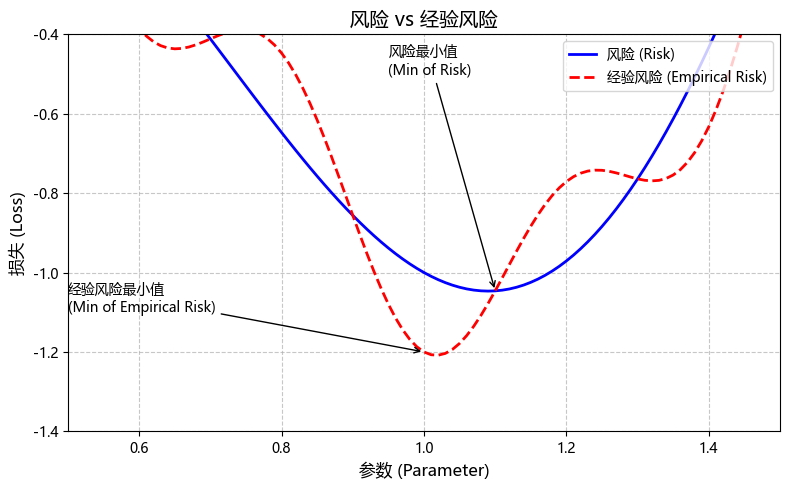

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib import rcParams

def f(x):
    return x * torch.cos(np.pi * x)

def g(x):
    return f(x) + 0.2 * torch.cos(5 * np.pi * x)

def annotate(text, xy, xytext):
    """添加箭头标注"""
    plt.annotate(text, xy=xy, xytext=xytext,
                 arrowprops=dict(arrowstyle='->', linewidth=1))

# 设置中文字体和图形参数
rcParams['font.sans-serif'] = ['Microsoft YaHei', 'Segoe UI Symbol', 'DejaVu Sans']
rcParams['axes.unicode_minus'] = False

# 创建数据
x = torch.arange(0.5, 1.5, 0.01)
f_values = f(x).numpy()
g_values = g(x).numpy()

# 绘制图形
fig, ax = plt.subplots(figsize=(8, 5))

# 绘制两条曲线
ax.plot(x.numpy(), f_values, 'b-', linewidth=2, label='风险 (Risk)')
ax.plot(x.numpy(), g_values, 'r--', linewidth=2, label='经验风险 (Empirical Risk)')

# 设置坐标轴标签
ax.set_xlabel('参数 (Parameter)', fontsize=12)
ax.set_ylabel('损失 (Loss)', fontsize=12)
ax.set_title('风险 vs 经验风险', fontsize=14)

# 添加图例
ax.legend(loc='upper right', fontsize=10)

# 添加网格
ax.grid(True, linestyle='--', alpha=0.7)

# 添加标注
annotate('经验风险最小值\n(Min of Empirical Risk)',
         (1.0, g_values[np.abs(x.numpy()-1.0).argmin()]),
         (0.5, -1.1))

annotate('风险最小值\n(Min of Risk)',
         (1.1, f_values[np.abs(x.numpy()-1.1).argmin()]),
         (0.95, -0.5))

# 设置坐标轴范围
ax.set_xlim(0.5, 1.5)
ax.set_ylim(-1.4, -0.4)

# 显示图形
plt.tight_layout()
plt.show()

### 深度学习中的优化挑战
- 关于解析解和数值解的理解：解析解就是可以直接公式（代数变换、微积分推导）推导出的精确解，可解释性强，数值解就是通过数值计算（迭代算法等）得到的近似解，深度学习中的神经网络损失函数就是用的数值解的方式，因为基本上在神经网络里面数据的维度都超级高，局部极小值一般也有无数个，没办法写出闭合的表达式，计算起来计算量大得不现实。
- 关于鞍点（梯度为零，伪装成极值点）的说法：就是像当前的损失走到了一个类似山脊的地方，左右走都能下降，但是前后走却不怎么变化（一般$\mathrm{SGD}$可能会被困在这附近，带动量的可以冲过鞍点区域，$\mathrm{Adam}$可以更好的逃离鞍点区域）。
- 海森矩阵：二阶导数矩阵，描述各个方向上的曲率，如下图（其中$n$就是多元函数的元数）,可通过海森矩阵的特征值的正负来判断是否是鞍点（目前其实不适用）。

![海森矩阵](../image/HessianMatrix.png)

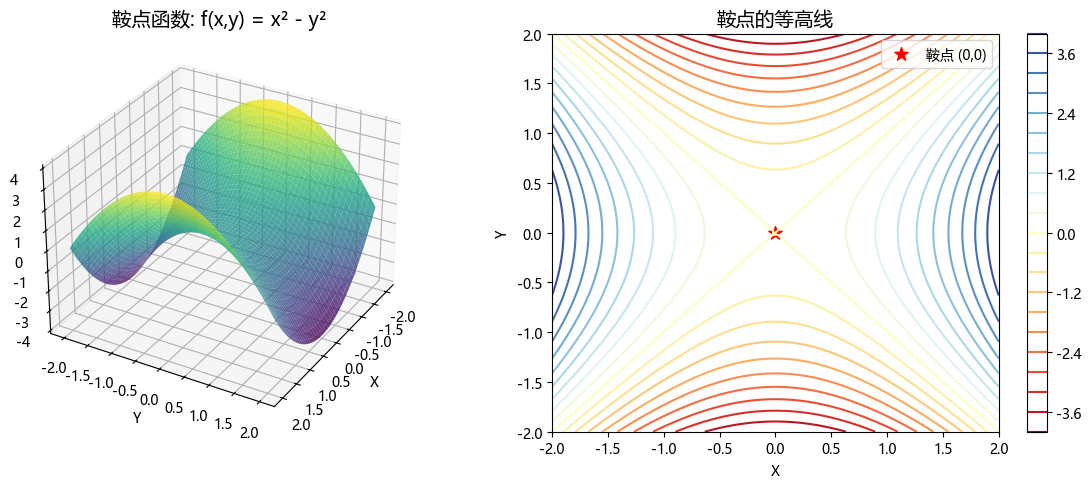

海森矩阵特征值: [ 2. -2.]
特征值一正一负 → 确认是鞍点！


In [3]:
# 定义经典的鞍点函数：f(x,y) = x^2 - y^2
def saddle_function(x, y):
    return x**2 - y**2

# 创建网格
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
X, Y = np.meshgrid(x, y)
Z = saddle_function(X, Y)

# 绘制3D曲面
fig = plt.figure(figsize=(12, 5))

# 3D图
ax1 = fig.add_subplot(121, projection='3d')
surf = ax1.plot_surface(X, Y, Z, cmap='viridis', alpha=0.8, linewidth=0)
ax1.set_title('鞍点函数: f(x,y) = x² - y²', fontsize=14)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('f(x,y)')
ax1.view_init(30, 30)

# 等高线图
ax2 = fig.add_subplot(122)
contour = ax2.contour(X, Y, Z, 20, cmap='RdYlBu')
ax2.set_title('鞍点的等高线', fontsize=14)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
plt.colorbar(contour, ax=ax2)

# 标记鞍点(0,0)
ax2.scatter(0, 0, color='red', s=100, marker='*', label='鞍点 (0,0)')
ax2.legend()

plt.tight_layout()
plt.show()

# 计算海森矩阵特征值
H = np.array([[2, 0],  # ∂²f/∂x² = 2
              [0, -2]]) # ∂²f/∂y² = -2
eigenvalues = np.linalg.eigvals(H)
print(f"海森矩阵特征值: {eigenvalues}")
print("特征值一正一负 → 确认是鞍点！")

## 凸性
- 这个凸性的理论可以用来确认排除鞍点的影响（伪装）
- 凸集：就是一个“没有洞、没有凹陷”的集合（就像是这个集合所构建的一个几何图像，任意两点的连线都不会跑到图像外面去）。
- 凸函数：定义在凸集上的函数。
- 二者结合的凸优化理论可以创造一个没有陷阱（鞍点之类的）路径明确的优化地形，无论从哪里开始最终都能走到唯一的最低点（全局最优解）

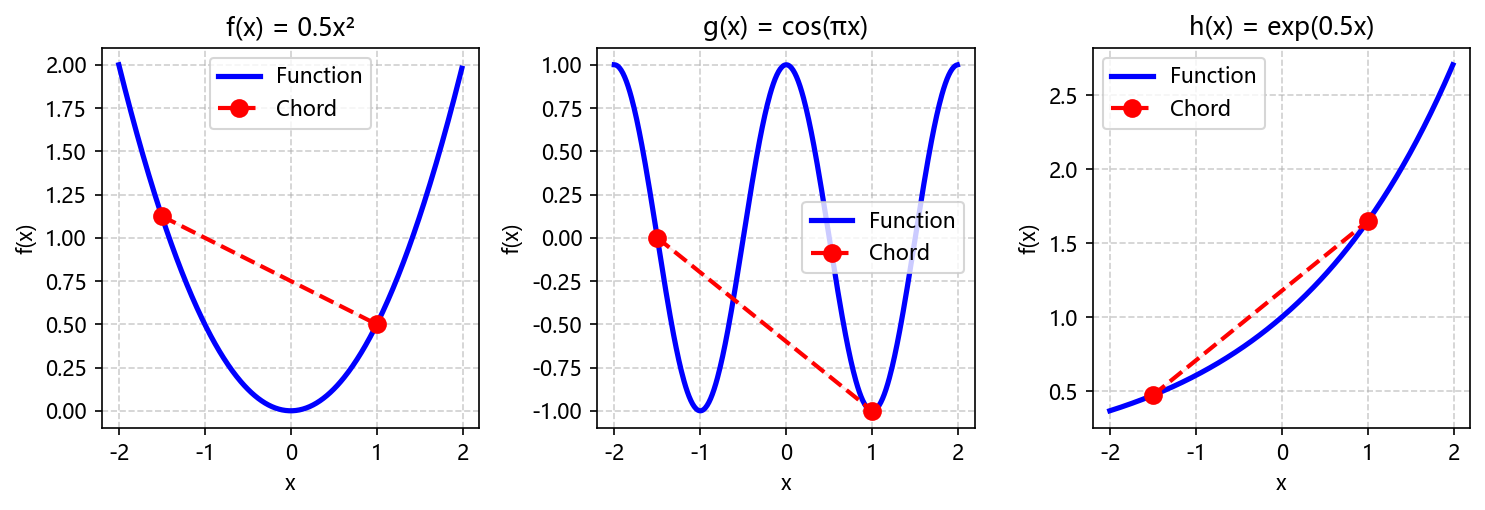

In [4]:
# 定义三个函数
f = lambda x: 0.5 * x**2  # 凸函数
g = lambda x: torch.cos(np.pi * x)  # 非凸函数
h = lambda x: torch.exp(0.5 * x)  # 凸函数

# 创建数据点
x = torch.arange(-2, 2, 0.01)
# 定义线段的两端点（用于连接演示凸性）
segment = torch.tensor([-1.5, 1])

# 设置图形输出为矢量图格式（可选，不影响显示）
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.format'] = 'svg'

# 创建1行3列的子图
fig, axes = plt.subplots(1, 3, figsize=(10, 3.5))

# 为每个子图绘制对应的函数
for ax, func, title in zip(axes, [f, g, h], ['f(x) = 0.5x²', 'g(x) = cos(πx)', 'h(x) = exp(0.5x)']):
    # 绘制主函数曲线
    ax.plot(x.numpy(), func(x).numpy(), 'b-', linewidth=2.5, label='Function')

    # 计算并绘制连接线段（弦）
    segment_y = func(segment)
    ax.plot(segment.numpy(), segment_y.numpy(), 'r--o', linewidth=2, markersize=8, label='Chord')

    # 填充弦上方的区域，直观展示凸性：弦在函数曲线上方
    ax.fill_between(segment.numpy(),
                    segment_y.numpy(),
                    func(segment).numpy(),
                    color='red', alpha=0.1)

    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlabel('x')
    ax.set_ylabel('f(x)')
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()

- 詹森不等式：就是说对于凸函数，函数的平均值 $\geqslant$ 平均值的函数
### 关于凸函数的性质
- 下述涉及到的理论在目前的应用是，在深度学习里面，整体的问题（网络）可能不具有凸性保证，但是目前是将这种凸性融入到网络的关键部分（比如激活函数、损失函数、正则化项这些部件；也就是在一个整体非凸的优化问题，在局部的强凸区域，优化算法可能已又很好的局部收敛保证）
- 在凸函数中，局部极小值就是全局极小值（这是凸函数的定义所带来的变化，对损失函数来说的话，“既然无法让整个地形（损失构成的空间）变成碗状（凸函数），那就确保关键路径是平滑的下坡，并沿途修建坚固的营地（局部凸区域）”，比如$\mathrm{ReLU}$激活函数，又比如损失函数在调整最后一层参数时，面对的是一个凸地形（就是最后一层输出的时候那个函数就是一个凸函数），正则化项（$L1、L2$范数本身就是凸的））
-下水平集：就是对一个函数和一个实数来说，这个函数的函数值不超过该实数的点构成的集合就是它们的下水平集（对一个凸函数，它的任何一个“等高线下方的区域”形状都是“饱满的”，没有凹陷）
- 海森矩阵就是多元函数的二阶导数组合成的（和数学一样利用二阶导数来判断函数的凹凸性）
### 约束
- 约束优化问题可转换为拉格朗日函数的鞍点优化问题（拉格朗日函数的鞍点就是原始约束优化问题的最优解）。
- 惩罚：就是构造一个惩罚函数，当优化结果超出约束条件时会使用惩罚系数，让其趋于无穷大来让模型判断其结果不可接受使其解逼近原约束问题的解（拉格朗日函数里面的那个系数就是这个惩罚系数的意思）。
- 投影：就是在迭代算法（梯度下降）的过程中，某一步不在约束内了，就使用投影的方法（到约束域的投影）找到在约束域且离其最近的点（这个过程的复杂性取决于约束域的形状）。

## 梯度下降
- 就是 原参数-(学习率乘以损失函数对该参数的偏导数)=更新后的参数
### 一维梯度下降
- 就是优化变量只有一个的梯度下降方法

梯度下降轨迹: [10.0, 6.0, 3.5999999999999996, 2.1599999999999997, 1.2959999999999998, 0.7775999999999998, 0.46655999999999986, 0.2799359999999999, 0.16796159999999993, 0.10077695999999996, 0.06046617599999997]
最终值: x = 0.0605, f(x) = 0.0037


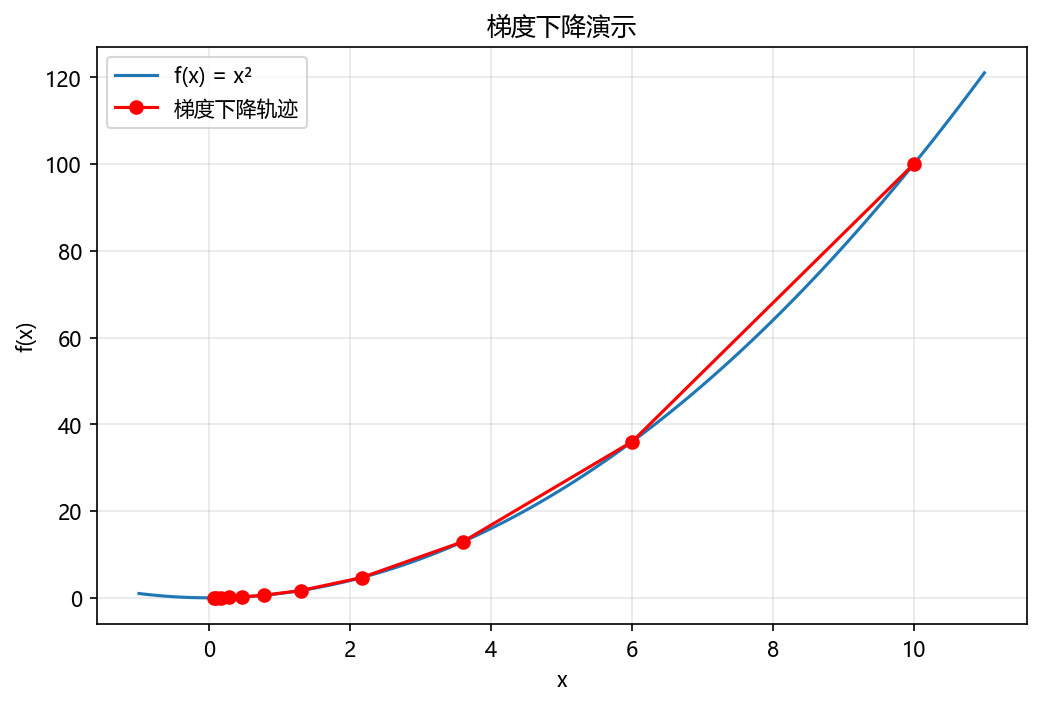

In [5]:
# 定义函数和梯度
def f(x):
    return x ** 2

def f_grad(x):
    return 2 * x

# 梯度下降算法
def gd(eta, f_grad, steps=10):
    x = 10.0
    results = [x]
    for i in range(steps):
        x -= eta * f_grad(x)
        results.append(x)
    return results

# 可视化函数
def show_trace(results, f):
    x_vals = np.linspace(-1, 11, 100)

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, f(x_vals), label='f(x) = x²')
    plt.plot(results, [f(x) for x in results], 'ro-', label='梯度下降轨迹')

    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('梯度下降演示')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

# 运行和显示
results = gd(0.2, f_grad, 10)
print(f"梯度下降轨迹: {results}")
print(f"最终值: x = {results[-1]:.4f}, f(x) = {f(results[-1]):.4f}")
show_trace(results, f)

- 学习率：就是控制梯度更新速度的参数。

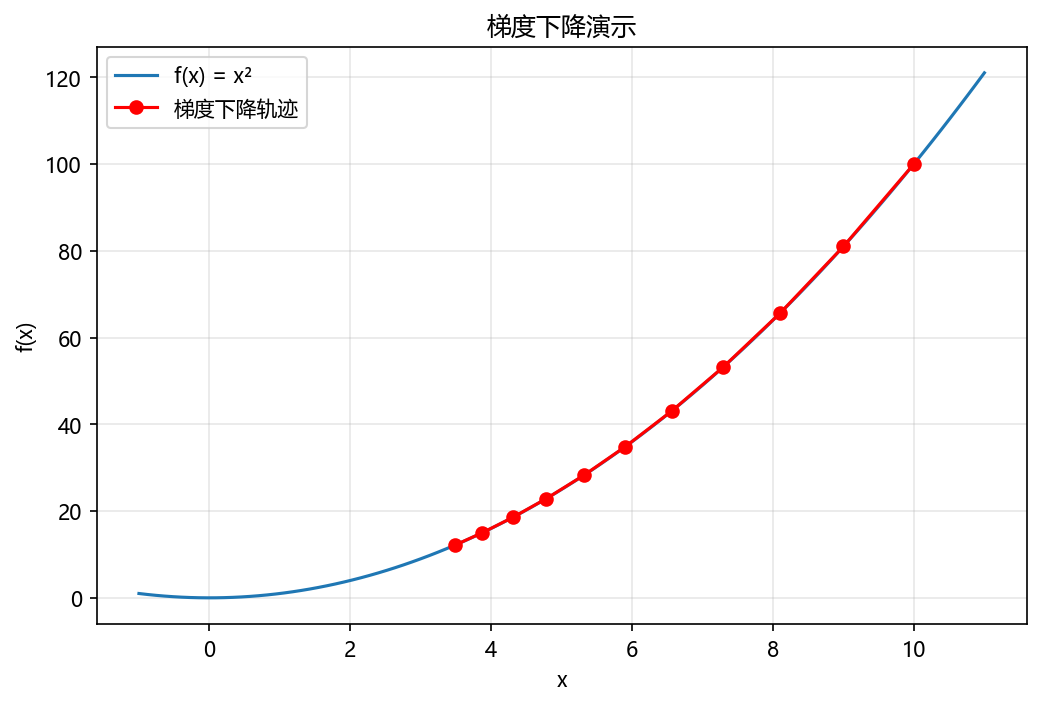

In [6]:
# 只运行学习率为0.05的情况
eta = 0.05
results = gd(eta, f_grad, 10)
show_trace(results, f)

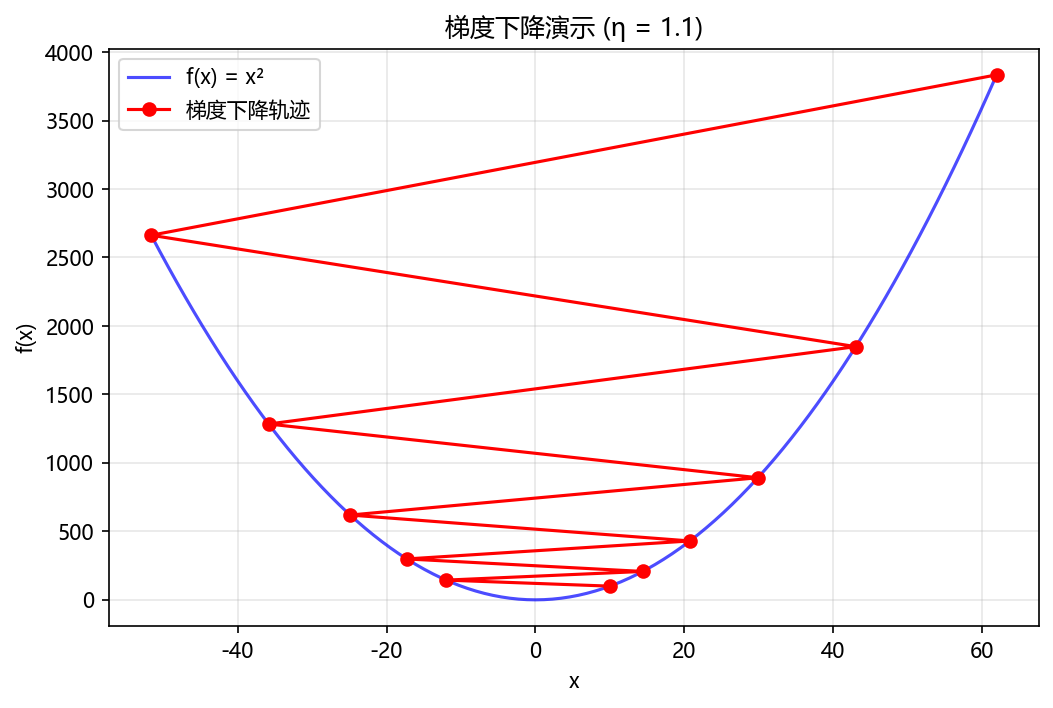

学习率 η = 1.1
轨迹: [10.0, -12.0, 14.4, -17.28, 20.736, -24.8832, 29.8598, -35.8318, 42.9982, -51.5978, 61.9174]
最终: x = 61.9174, f(x) = 3833.7600


In [7]:
# 定义函数和梯度
f = lambda x: x**2
f_grad = lambda x: 2*x

# 梯度下降算法（返回一个元组）
def gd(eta, f_grad, steps=10):
    x = 10.0
    results = [x]
    for i in range(steps):
        x -= eta * f_grad(x)
        results.append(x)
    return results, eta

# 可视化函数（接受元组）
def show_trace(gd_result, f):
    results, eta = gd_result
    x_vals = np.linspace(min(min(results), -2), max(max(results), 2), 100)

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, f(x_vals), 'b-', label='f(x) = x²', alpha=0.7)
    plt.plot(results, [f(x) for x in results], 'ro-', label='梯度下降轨迹', markersize=6)

    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(f'梯度下降演示 (η = {eta})')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    print(f"学习率 η = {eta}")
    print(f"轨迹: {[round(x, 4) for x in results]}")
    print(f"最终: x = {results[-1]:.4f}, f(x) = {f(results[-1]):.4f}")

# 直接调用 show_trace(gd(1.1, f_grad), f)
show_trace(gd(1.1, f_grad), f)

- 局部最小值：高学习率有时候会导致函数到一个局部的最小值

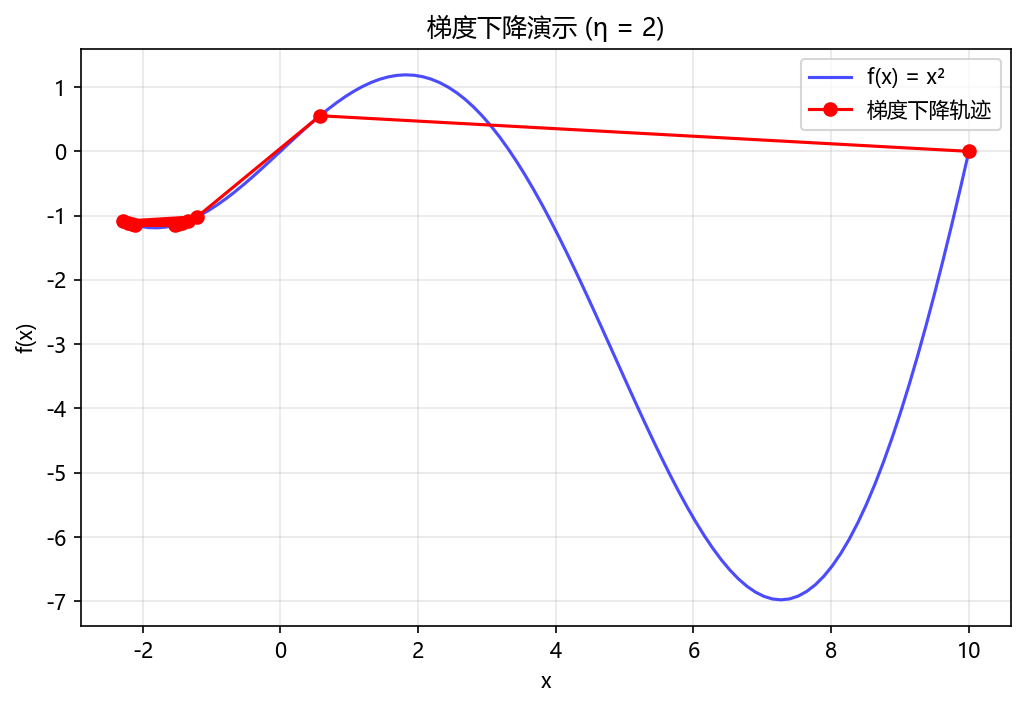

学习率 η = 2
轨迹: [10.0, np.float64(0.5752), np.float64(-1.2066), np.float64(-2.2796), np.float64(-1.3434), np.float64(-2.2068), np.float64(-1.4258), np.float64(-2.1546), np.float64(-1.4839), np.float64(-2.1144), np.float64(-1.5282)]
最终: x = -1.5282, f(x) = -1.1488


In [8]:
# 定义常数 c
c = 0.15 * np.pi

# 定义目标函数和梯度
def f(x):
    return x * np.cos(c * x)

def f_grad(x):
    return np.cos(c * x) - c * x * np.sin(c * x)

show_trace(gd(2, f_grad), f)

### 多元梯度下降
- 核心的东西都和一维梯度下降是一致的，就是把单个偏导，变成偏导矩阵来操作了。

迭代 1, x1: -4.000000, x2: -1.200000
迭代 2, x1: -3.200000, x2: -0.720000
迭代 3, x1: -2.560000, x2: -0.432000
迭代 4, x1: -2.048000, x2: -0.259200
迭代 5, x1: -1.638400, x2: -0.155520
迭代 6, x1: -1.310720, x2: -0.093312
迭代 7, x1: -1.048576, x2: -0.055987
迭代 8, x1: -0.838861, x2: -0.033592
迭代 9, x1: -0.671089, x2: -0.020155
迭代 10, x1: -0.536871, x2: -0.012093
迭代 11, x1: -0.429497, x2: -0.007256
迭代 12, x1: -0.343597, x2: -0.004354
迭代 13, x1: -0.274878, x2: -0.002612
迭代 14, x1: -0.219902, x2: -0.001567
迭代 15, x1: -0.175922, x2: -0.000940
迭代 16, x1: -0.140737, x2: -0.000564
迭代 17, x1: -0.112590, x2: -0.000339
迭代 18, x1: -0.090072, x2: -0.000203
迭代 19, x1: -0.072058, x2: -0.000122
迭代 20, x1: -0.057646, x2: -0.000073


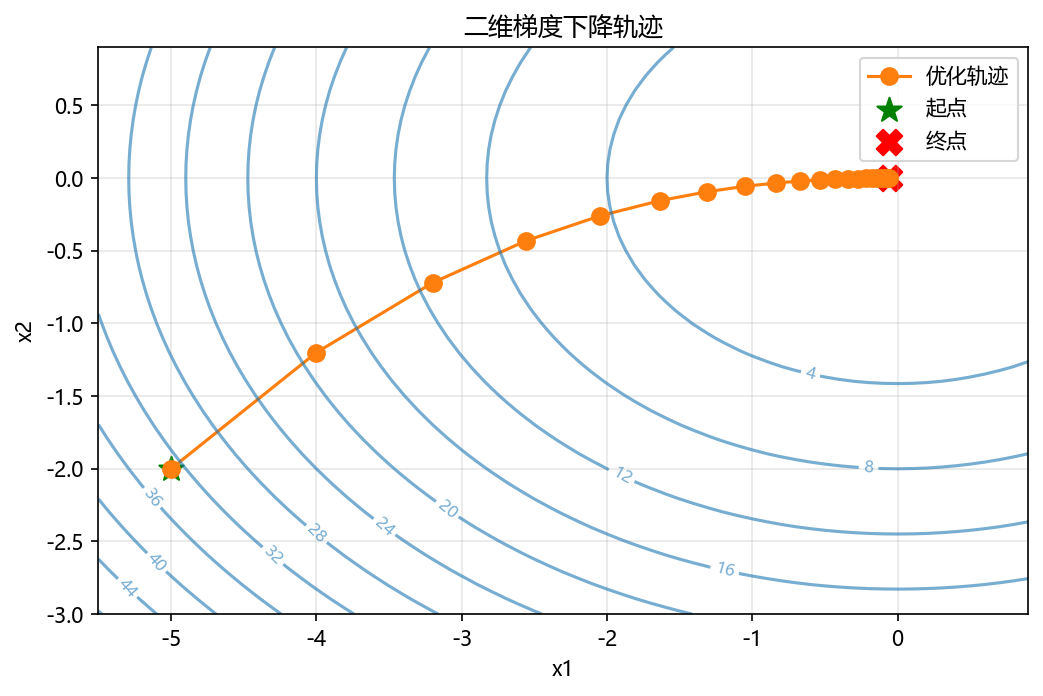

In [9]:
def train_2d(trainer, steps=20, f_grad=None):
    """用定制的训练机优化2D目标函数"""
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]

    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
        print(f'迭代 {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')

    return results

def show_trace_2d(f, results):
    """显示优化过程中2D变量的轨迹"""
    plt.figure(figsize=(8, 6))

    # 解压轨迹坐标
    x1_vals, x2_vals = zip(*results)
    plt.plot(x1_vals, x2_vals, '-o', color='#ff7f0e', markersize=8, label='优化轨迹')

    # 绘制起点和终点
    plt.scatter(x1_vals[0], x2_vals[0], color='green', s=150, marker='*', label='起点')
    plt.scatter(x1_vals[-1], x2_vals[-1], color='red', s=150, marker='X', label='终点')

    # 创建等高线网格
    x1_grid, x2_grid = np.meshgrid(
        np.arange(-5.5, 1.0, 0.1),
        np.arange(-3.0, 1.0, 0.1),
        indexing='ij'
    )

    # 计算函数值
    f_vals = f(x1_grid, x2_grid)

    # 绘制等高线
    contour = plt.contour(x1_grid, x2_grid, f_vals, levels=15, colors='#1f77b4', alpha=0.6)
    plt.clabel(contour, inline=True, fontsize=8)

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('二维梯度下降轨迹')
    plt.grid(True, alpha=0.3)
    plt.legend()

    # 调整坐标轴比例，使等高线显示为正圆
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()

# 定义二维目标函数
def f_2d(x1, x2):
    """目标函数: f(x1, x2) = x1^2 + 2*x2^2"""
    return x1 ** 2 + 2 * x2 ** 2

def f_2d_grad(x1, x2):
    """目标函数的梯度"""
    return (2 * x1, 4 * x2)

def gd_2d(x1, x2, s1, s2, f_grad):
    """二维梯度下降更新"""
    g1, g2 = f_grad(x1, x2)
    return (x1 - eta * g1, x2 - eta * g2, 0, 0)

# 设置学习率并运行
eta = 0.1
results = train_2d(gd_2d, f_grad=f_2d_grad)
show_trace_2d(f_2d, results)

### 自适应方法
- 牛顿法：就是使用泰勒展开来进行求导等计算。

迭代10次后, x: 0.0


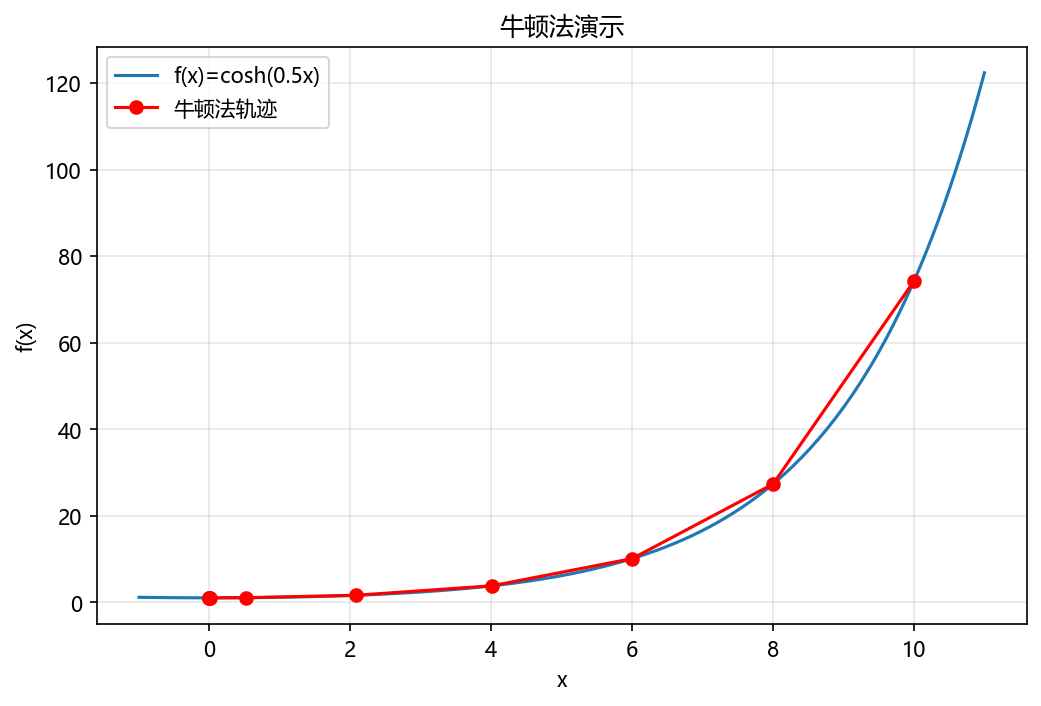

轨迹: [10.0, np.float64(8.0002), np.float64(6.0015), np.float64(4.0114), np.float64(2.0825), np.float64(0.5258), np.float64(0.0118), np.float64(0.0), np.float64(0.0), np.float64(0.0), np.float64(0.0)]


In [10]:
# 定义常数 c
c = 0.5

# 定义目标函数及其导数
def f(x):
    return np.cosh(c * x)

def f_grad(x):
    return c * np.sinh(c * x)

def f_hess(x):
    return c**2 * np.cosh(c * x)

# 牛顿法
def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(x)
    print('迭代10次后, x:', x)
    return results

# 可视化
def show_trace(results, f):
    x_vals = np.linspace(min(results)-1, max(results)+1, 200)

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, f(x_vals), label=f'f(x)=cosh({c}x)')
    plt.plot(results, [f(x) for x in results], 'ro-', label='牛顿法轨迹')

    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('牛顿法演示')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    print(f"轨迹: {[round(x, 4) for x in results]}")

# 运行
results = newton(eta=1)
show_trace(results, f)

迭代10次后, x: 1.825685, f(x): 1.190683


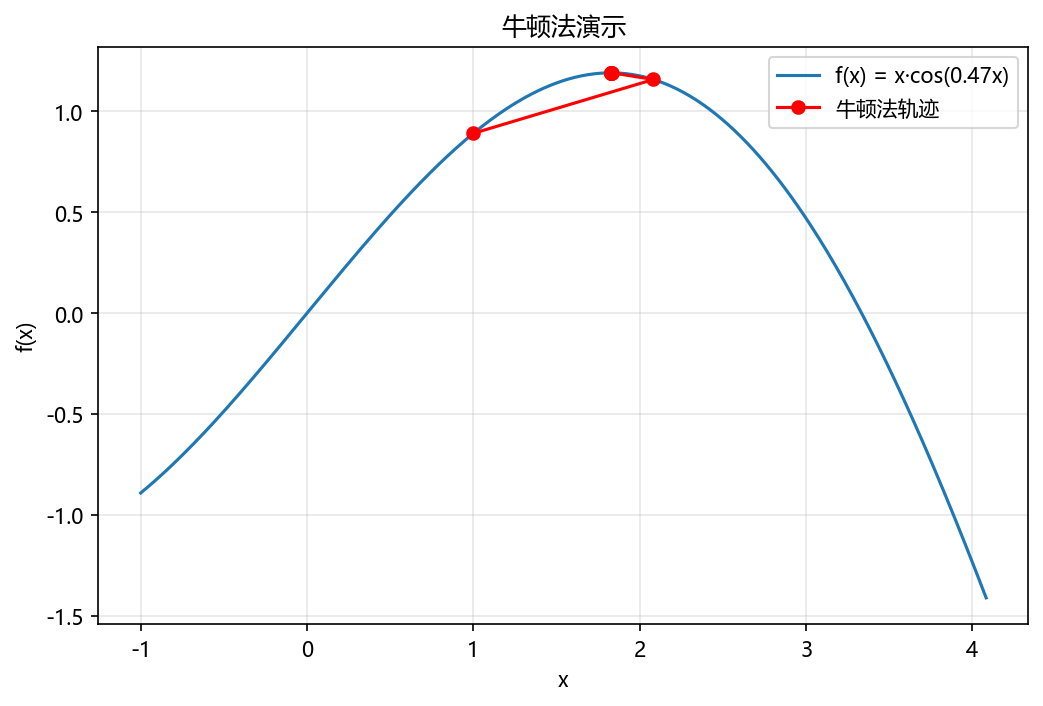

轨迹: [1.0, np.float64(2.082), np.float64(1.8327), np.float64(1.8257), np.float64(1.8257), np.float64(1.8257), np.float64(1.8257), np.float64(1.8257), np.float64(1.8257), np.float64(1.8257), np.float64(1.8257)]


In [11]:
# 定义常数 c
c = 0.15 * np.pi

# 定义目标函数及其导数
def f(x):
    return x * np.cos(c * x)

def f_grad(x):
    return np.cos(c * x) - c * x * np.sin(c * x)

def f_hess(x):
    return - 2 * c * np.sin(c * x) - x * c**2 * np.cos(c * x)

# 牛顿法
def newton(eta=1):
    x = 1.0  # 注意：这个函数在x=10处梯度极大，可能会发散，所以改为1.0
    results = [x]
    for i in range(10):
        # 牛顿法更新：x = x - η * f'(x) / f''(x)
        # 防止除零错误
        hess = f_hess(x)
        if abs(hess) < 1e-12:
            hess = 1e-12 if hess >= 0 else -1e-12
        x -= eta * f_grad(x) / hess
        results.append(x)
    print(f'迭代10次后, x: {x:.6f}, f(x): {f(x):.6f}')
    return results

# 可视化
def show_trace(results, f):
    x_vals = np.linspace(min(results)-2, max(results)+2, 400)

    plt.figure(figsize=(8, 5))
    plt.plot(x_vals, f(x_vals), label=f'f(x) = x·cos({c:.2f}x)')
    plt.plot(results, [f(x) for x in results], 'ro-', label='牛顿法轨迹')

    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title('牛顿法演示')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

    print(f"轨迹: {[round(x, 4) for x in results]}")

# 运行
results = newton(eta=1)
show_trace(results, f)

- 关于牛顿法的弊端就是，计算成本高，随着优化步骤的增加，损失可能会上升，容易收敛到极大值点或者鞍点。但在凸问题中好用。
## 随机梯度下降
- 就是从开始是整个数据集的样本都计算梯度来更新参数，变成每次迭代都只随机选一个样本来计算梯度更新索引。从原始定义来看随机梯度是完整梯度的一个无偏估计（平均的来看，起到一种隐式的正则化的作用）
### 随机梯度更新

epoch 1, x1: -4.128078, x2: -1.189627
epoch 2, x1: -3.285695, x2: -0.704894
epoch 3, x1: -2.587020, x2: -0.349126
epoch 4, x1: -1.905604, x2: -0.043838
epoch 5, x1: -1.451214, x2: 0.021797
epoch 6, x1: -0.939835, x2: -0.167070
epoch 7, x1: -0.516135, x2: -0.087744
epoch 8, x1: -0.422979, x2: 0.048464
epoch 9, x1: -0.285312, x2: -0.243367
epoch 10, x1: -0.153145, x2: -0.214822
epoch 11, x1: -0.129555, x2: -0.242872
epoch 12, x1: -0.120841, x2: -0.130349
epoch 13, x1: -0.142522, x2: -0.114272
epoch 14, x1: -0.063313, x2: -0.108060
epoch 15, x1: -0.260376, x2: -0.210586
epoch 16, x1: -0.199871, x2: -0.014324
epoch 17, x1: -0.092818, x2: -0.015363
epoch 18, x1: -0.028182, x2: -0.069540
epoch 19, x1: 0.028859, x2: 0.040272
epoch 20, x1: 0.245104, x2: 0.128031
epoch 21, x1: 0.247222, x2: 0.023330
epoch 22, x1: 0.105397, x2: -0.042824
epoch 23, x1: 0.035376, x2: -0.038451
epoch 24, x1: 0.029948, x2: -0.082287
epoch 25, x1: -0.197839, x2: -0.030354
epoch 26, x1: -0.285929, x2: -0.028846
epoch 

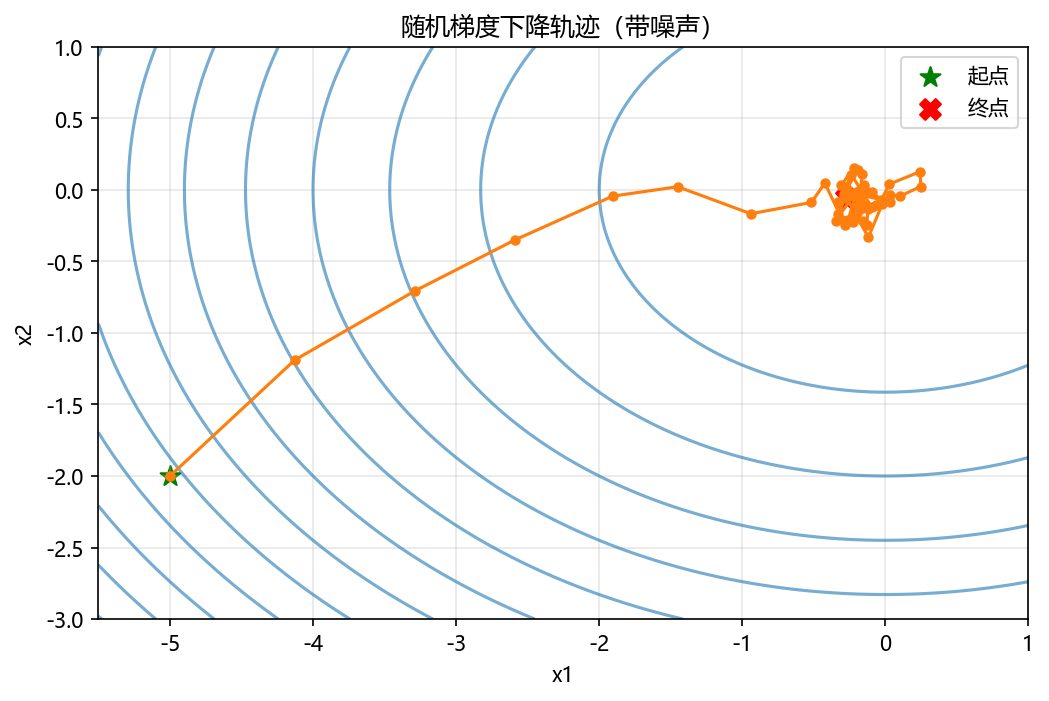

In [12]:
# 目标函数及其梯度
def f(x1, x2):
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):
    return 2 * x1, 4 * x2

# 常数学习率函数
def constant_lr():
    return 1

# 随机梯度下降（带噪声）
def sgd(x1, x2, s1, s2, f_grad, eta=0.1, lr_func=constant_lr):
    g1, g2 = f_grad(x1, x2)

    # 添加随机噪声到梯度
    g1 += np.random.normal(0.0, 1)
    g2 += np.random.normal(0.0, 1)

    eta_t = eta * lr_func()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

# 训练函数（2D）
def train_2d(trainer, steps=50, f_grad=None):
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]

    for i in range(steps):
        if f_grad:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2, f_grad)
        else:
            x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
        print(f'epoch {i + 1}, x1: {float(x1):f}, x2: {float(x2):f}')

    return results

# 可视化函数（2D）
def show_trace_2d(f, results):
    # 解包轨迹坐标
    x1_vals, x2_vals = zip(*results)

    # 创建等高线网格
    x1_grid, x2_grid = np.meshgrid(
        np.linspace(-5.5, 1.0, 100),
        np.linspace(-3.0, 1.0, 100)
    )

    # 计算函数值
    f_vals = f(x1_grid, x2_grid)

    plt.figure(figsize=(8, 6))

    # 绘制等高线
    plt.contour(x1_grid, x2_grid, f_vals, levels=15, colors='#1f77b4', alpha=0.6)

    # 绘制轨迹
    plt.plot(x1_vals, x2_vals, '-o', color='#ff7f0e', markersize=4, linewidth=1.5)

    # 标记起点和终点
    plt.scatter(x1_vals[0], x2_vals[0], color='green', s=100, marker='*', label='起点')
    plt.scatter(x1_vals[-1], x2_vals[-1], color='red', s=100, marker='X', label='终点')

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title('随机梯度下降轨迹（带噪声）')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')

    plt.show()

# 运行
eta = 0.1
lr = constant_lr

# 训练并显示轨迹
results = train_2d(lambda x1, x2, s1, s2, f_grad: sgd(x1, x2, s1, s2, f_grad, eta, lr),
                   steps=50, f_grad=f_grad)
show_trace_2d(f, results)

- 虽然可以帮助跳出局部最小值点，但是花的优化步数比较长，并且最终的结果不稳定，需要更精细的学习率的调整
### 动态学习率
- 动态学习率的使用就是为了更好的适应在训练过程中不同阶段的特性
- 其核心就是：在训练初期的时候，使用一个较大的学习率来快速的脱离局部最优，中期的时候适中的学习率来稳定收敛，最后的时候使用小学习率来做精细的调整以此来接近最优解
-

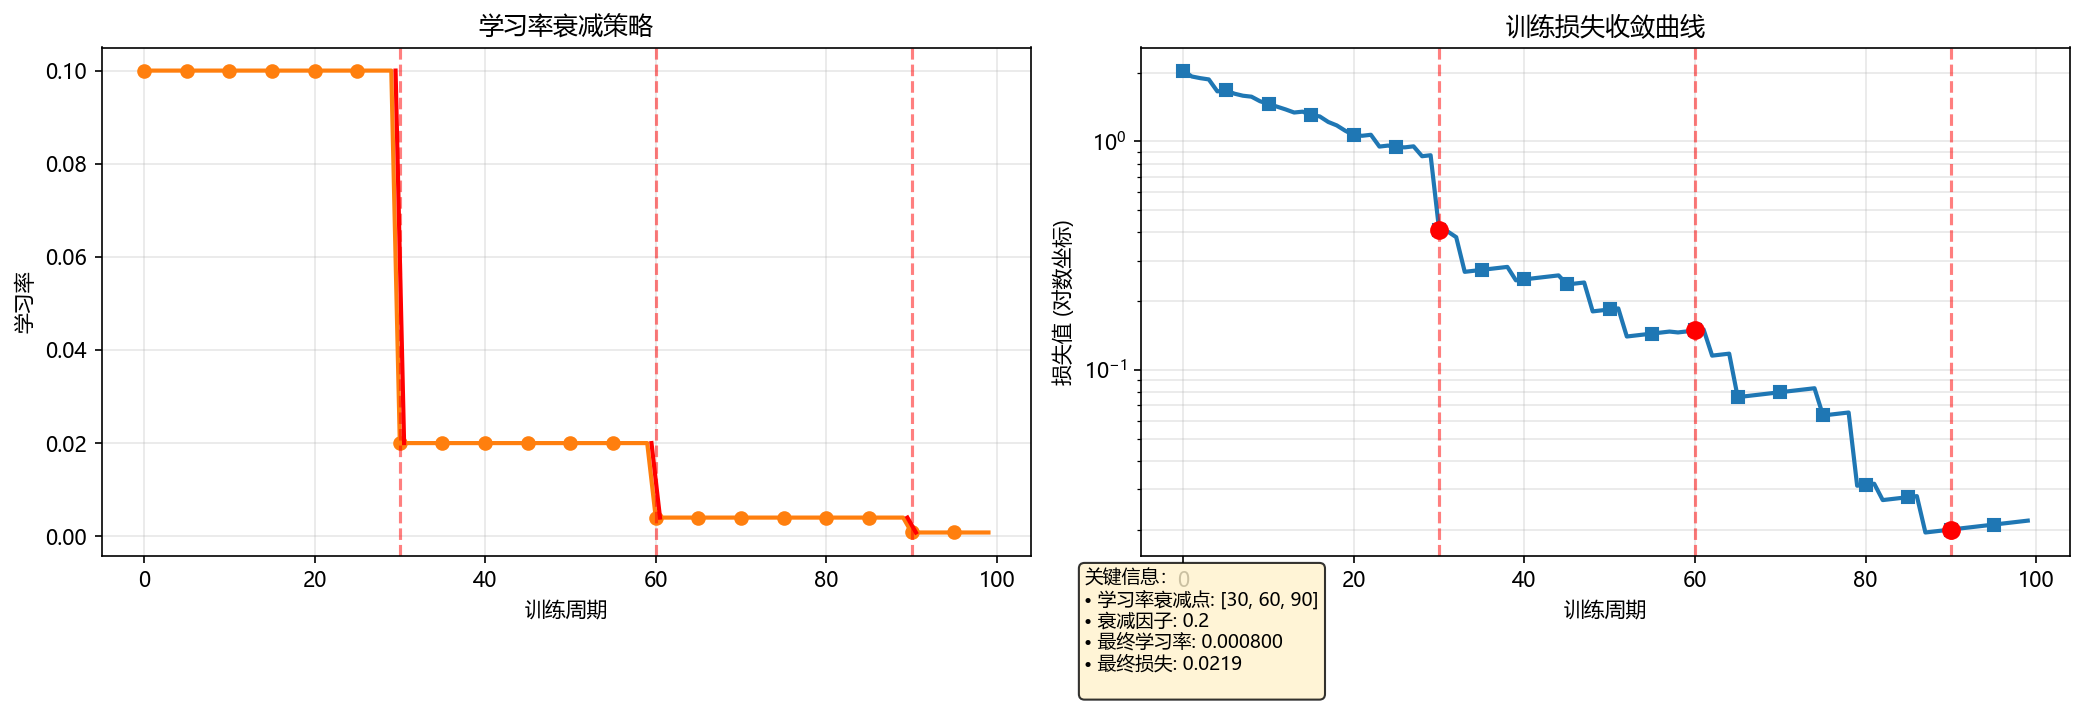

In [23]:
# 参数设置
initial_lr, min_lr = 0.1, 0.0001
epochs = np.arange(100)
drop_epochs, drop_rate = [30, 60, 90], 0.2

# 学习率计算函数
def step_decay(epoch):
    lr = initial_lr
    for drop in drop_epochs:
        if epoch >= drop:
            lr *= drop_rate
    return max(lr, min_lr)

lr_values = [step_decay(e) for e in epochs]

# 模拟损失函数
def simulate_loss(lr_values):
    losses = []
    base_loss = 2.0
    for i, (epoch, lr) in enumerate(zip(epochs, lr_values)):
        decay = np.exp(-epoch * 0.03)
        lr_effect = 0.5 * np.exp(-(lr - 0.01)**2 / 0.002) + 0.5
        current_loss = base_loss * decay * (1.5 - lr_effect) + np.random.normal(0, 0.05)
        current_loss = min(current_loss, losses[-1] * 1.01) if i > 0 else current_loss
        losses.append(max(current_loss, 0.01))
    return np.array(losses)

losses = simulate_loss(lr_values)

# 创建图表
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：学习率衰减曲线
axes[0].plot(epochs, lr_values, 'o-', markevery=5, linewidth=2, color='#FF7F0E')
for drop in drop_epochs:
    axes[0].axvline(x=drop, color='red', linestyle='--', alpha=0.5)
    lr_before, lr_after = step_decay(drop-1), step_decay(drop)
    axes[0].plot([drop-0.5, drop+0.5], [lr_before, lr_after], 'r-', linewidth=2)
axes[0].set(xlabel='训练周期', ylabel='学习率', title='学习率衰减策略')
axes[0].grid(True, alpha=0.3)

# 右图：损失收敛曲线
axes[1].semilogy(epochs, losses, 's-', markevery=5, linewidth=2, color='#1F77B4')
for drop in drop_epochs:
    axes[1].axvline(x=drop, color='red', linestyle='--', alpha=0.5)
    axes[1].plot(drop, losses[drop], 'ro', markersize=8)
axes[1].set(xlabel='训练周期', ylabel='损失值 (对数坐标)', title='训练损失收敛曲线')
axes[1].grid(True, alpha=0.3, which='both')

# 添加关键信息
info_text = f"""关键信息：
• 学习率衰减点: {drop_epochs}
• 衰减因子: {drop_rate}
• 最终学习率: {lr_values[-1]:.6f}
• 最终损失: {losses[-1]:.4f}
"""
plt.figtext(0.52, 0.02, info_text, fontsize=9,
            bbox=dict(boxstyle='round', facecolor='#FFF2CC', alpha=0.8))

plt.tight_layout(rect=[0, 0.08, 1, 0.95])
plt.show()

C:\Users\DaiYongle\AppData\Local\Temp\ipykernel_50900\3416567971.py:62: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Microsoft YaHei.
  plt.tight_layout()
D:\anaconda3\envs\DLL\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Microsoft YaHei.
  fig.canvas.print_figure(bytes_io, **kw)


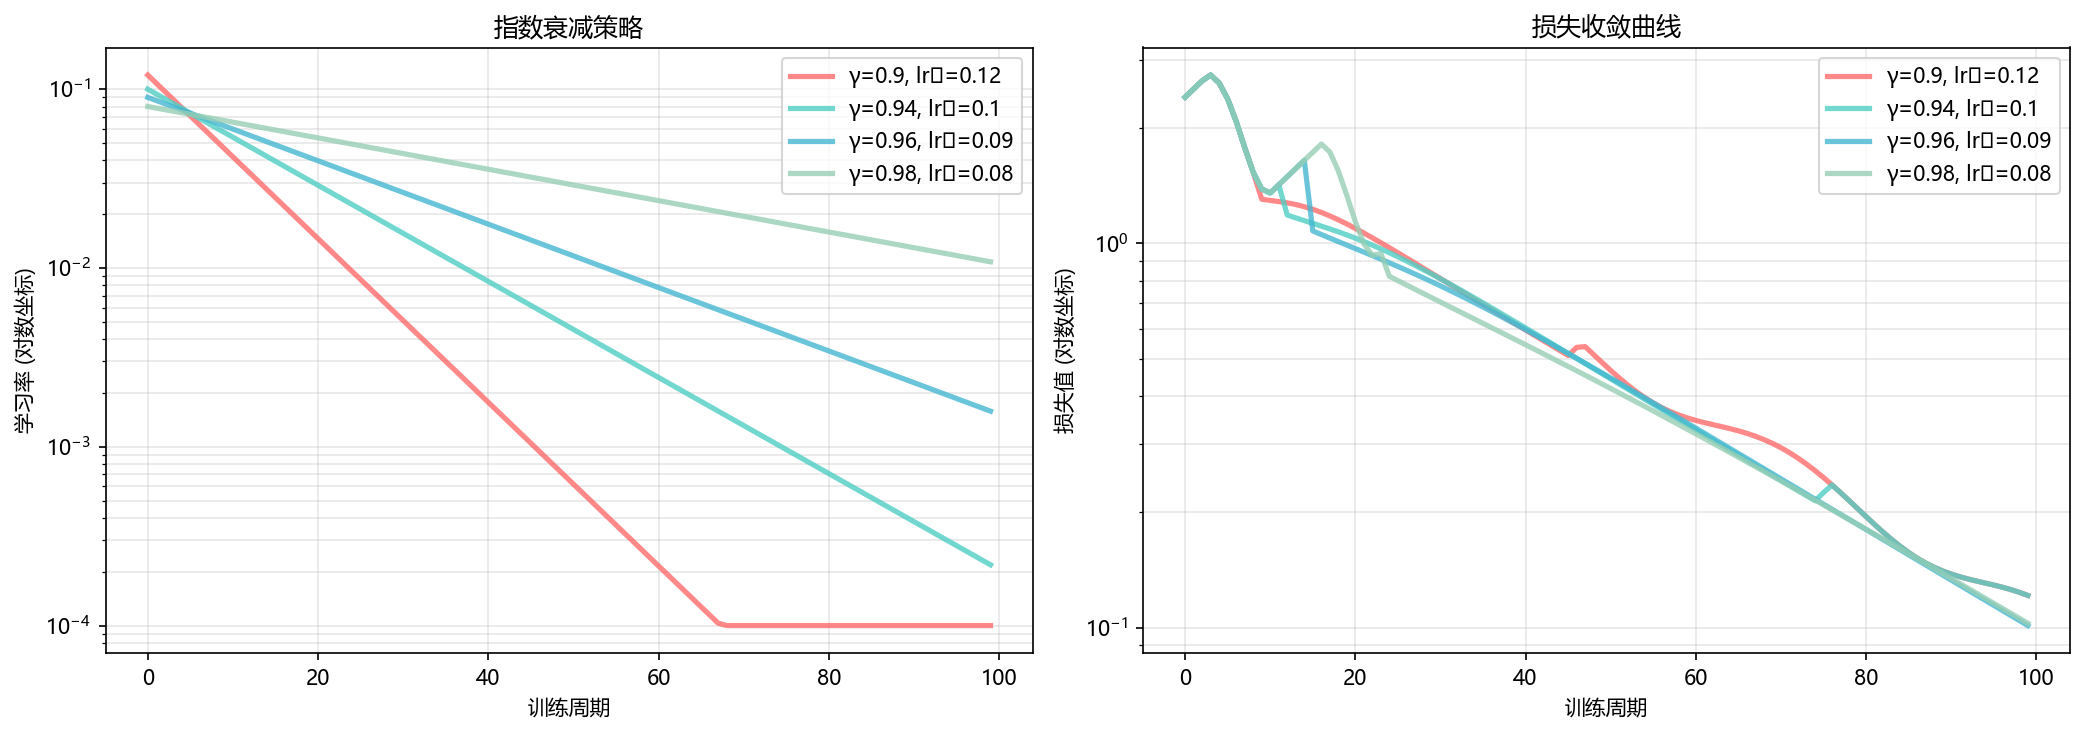

In [29]:
# 参数设置
epochs = np.arange(100)
decay_rates = [0.9, 0.94, 0.96, 0.98]
initial_lrs = [0.12, 0.1, 0.09, 0.08]  # 不同衰减率的初始学习率
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

# 指数衰减函数
def exponential_decay(epoch, decay_rate, init_lr):
    return max(init_lr * (decay_rate ** epoch), 0.0001)

# 模拟损失函数
def simulate_loss(lr_vals):
    losses = []
    base_loss = 2.0

    for i, (epoch, lr) in enumerate(zip(epochs, lr_vals)):
        base_decay = np.exp(-epoch * 0.03)

        if lr > 0.05:
            lr_penalty = 1.2 + 0.3 * np.sin(epoch * 0.5)
        elif lr < 0.001:
            lr_penalty = 1.1 + 0.1 * np.sin(epoch * 0.2)
        else:
            lr_penalty = 0.8 + 0.2 * np.exp(-(lr - 0.01)**2 / 0.001)

        current_loss = base_loss * base_decay * lr_penalty

        if i > 0:
            current_loss = min(current_loss, losses[-1] * 1.05)

        losses.append(max(current_loss, 0.01))

    return np.array(losses)

# 创建图表
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：学习率衰减策略
for dr, init_lr, color in zip(decay_rates, initial_lrs, colors):
    lr_vals = [exponential_decay(e, dr, init_lr) for e in epochs]
    axes[0].semilogy(epochs, lr_vals, linewidth=2.5, alpha=0.8,
                    label=f'γ={dr}, lr₀={init_lr}', color=color)

axes[0].set(xlabel='训练周期', ylabel='学习率 (对数坐标)', title='指数衰减策略')
axes[0].grid(True, alpha=0.3, which='both')
axes[0].legend(loc='upper right')

# 右图：损失收敛曲线
for dr, init_lr, color in zip(decay_rates, initial_lrs, colors):
    lr_vals = [exponential_decay(e, dr, init_lr) for e in epochs]
    losses = simulate_loss(lr_vals)
    axes[1].semilogy(epochs, losses, linewidth=2.5, alpha=0.8,
                    label=f'γ={dr}, lr₀={init_lr}', color=color)

axes[1].set(xlabel='训练周期', ylabel='损失值 (对数坐标)', title='损失收敛曲线')
axes[1].grid(True, alpha=0.3, which='both')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

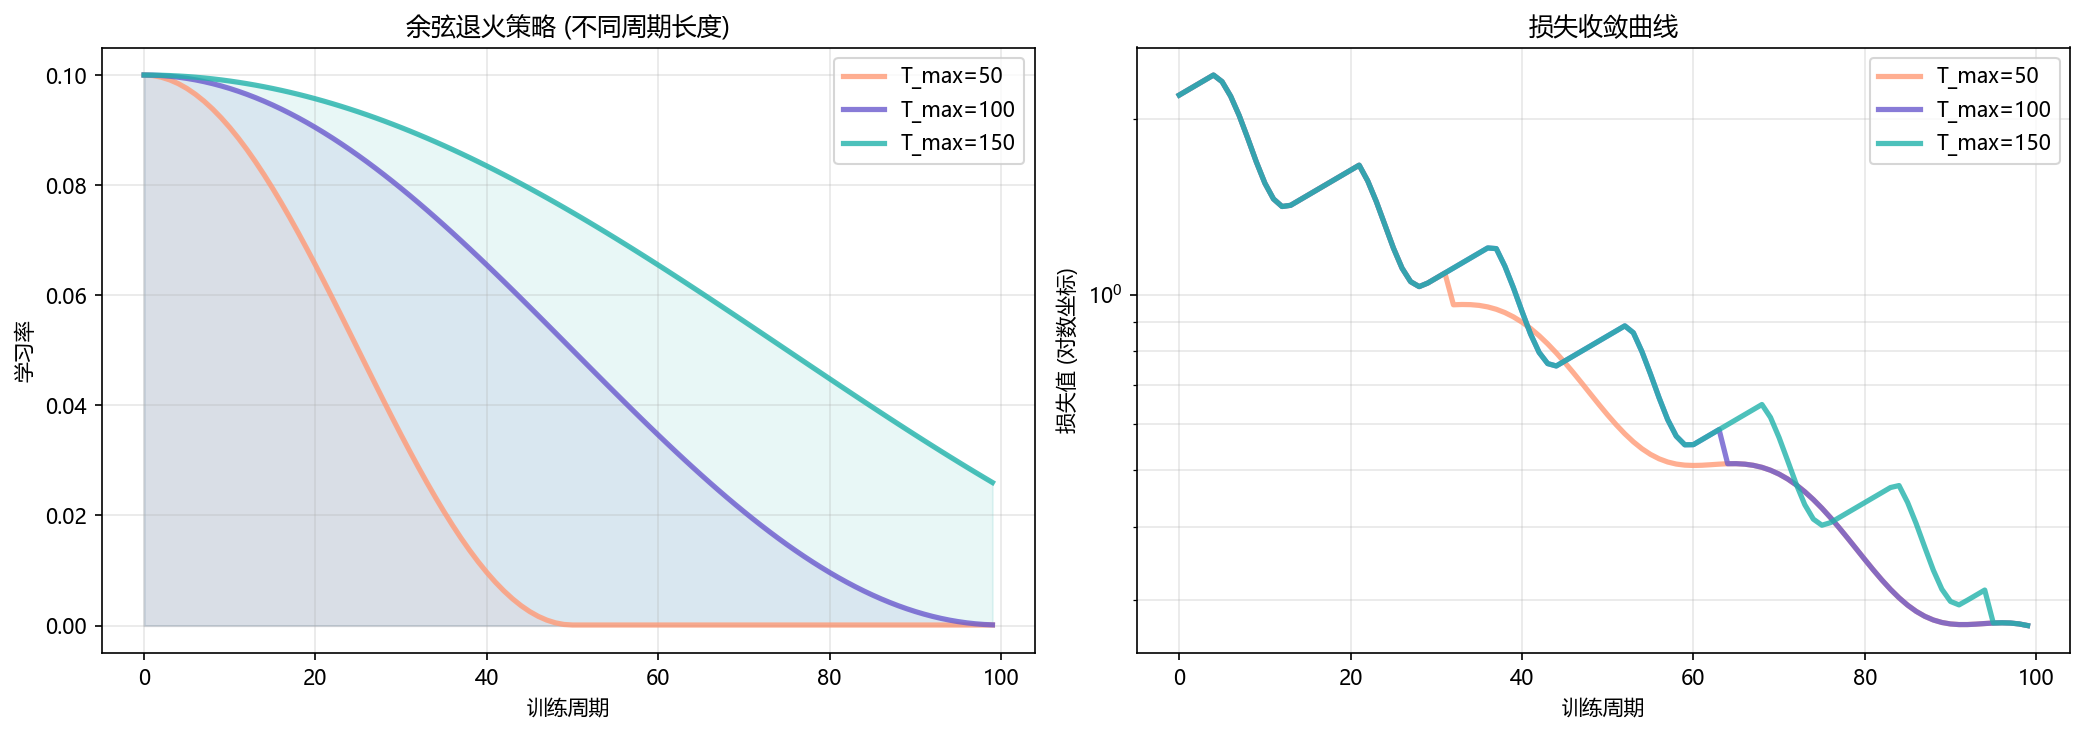

In [30]:
# 参数设置
initial_lr = 0.1
epochs = np.arange(100)

# 余弦退火函数
def cosine_decay(epoch, T_max=100, eta_min=0.0001):
    if epoch >= T_max:
        return eta_min
    cosine = 0.5 * (1 + np.cos(np.pi * epoch / T_max))
    lr = eta_min + (initial_lr - eta_min) * cosine
    return lr

# 计算不同周期长度的余弦退火
T_values = [50, 100, 150]
colors = ['#FF9A76', '#6A5ACD', '#20B2AA']

# 模拟损失函数
def simulate_loss(lr_vals):
    losses = []
    base_loss = 2.0

    for i, (epoch, lr) in enumerate(zip(epochs, lr_vals)):
        base_decay = np.exp(-epoch * 0.02)

        if lr > 0.03:  # 学习率较大时
            lr_penalty = 1.1 + 0.2 * np.sin(epoch * 0.4)
        else:  # 学习率较小时
            lr_penalty = 0.9 + 0.1 * np.sin(epoch * 0.2)

        current_loss = base_loss * base_decay * lr_penalty

        if i > 0:
            current_loss = min(current_loss, losses[-1] * 1.02)

        losses.append(max(current_loss, 0.01))

    return np.array(losses)

# 创建图表
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：不同周期长度的余弦退火策略
for T, color in zip(T_values, colors):
    lr_vals = [cosine_decay(e, T_max=T) for e in epochs]
    axes[0].plot(epochs, lr_vals, linewidth=2.5, alpha=0.8,
                label=f'T_max={T}', color=color)
    axes[0].fill_between(epochs, lr_vals, alpha=0.1, color=color)

axes[0].set_xlabel('训练周期')
axes[0].set_ylabel('学习率')
axes[0].set_title('余弦退火策略 (不同周期长度)')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper right')

# 右图：对应的损失收敛曲线
for T, color in zip(T_values, colors):
    lr_vals = [cosine_decay(e, T_max=T) for e in epochs]
    losses = simulate_loss(lr_vals)
    axes[1].semilogy(epochs, losses, linewidth=2.5, alpha=0.8,
                    label=f'T_max={T}', color=color)

axes[1].set_xlabel('训练周期')
axes[1].set_ylabel('损失值 (对数坐标)')
axes[1].set_title('损失收敛曲线')
axes[1].grid(True, alpha=0.3, which='both')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

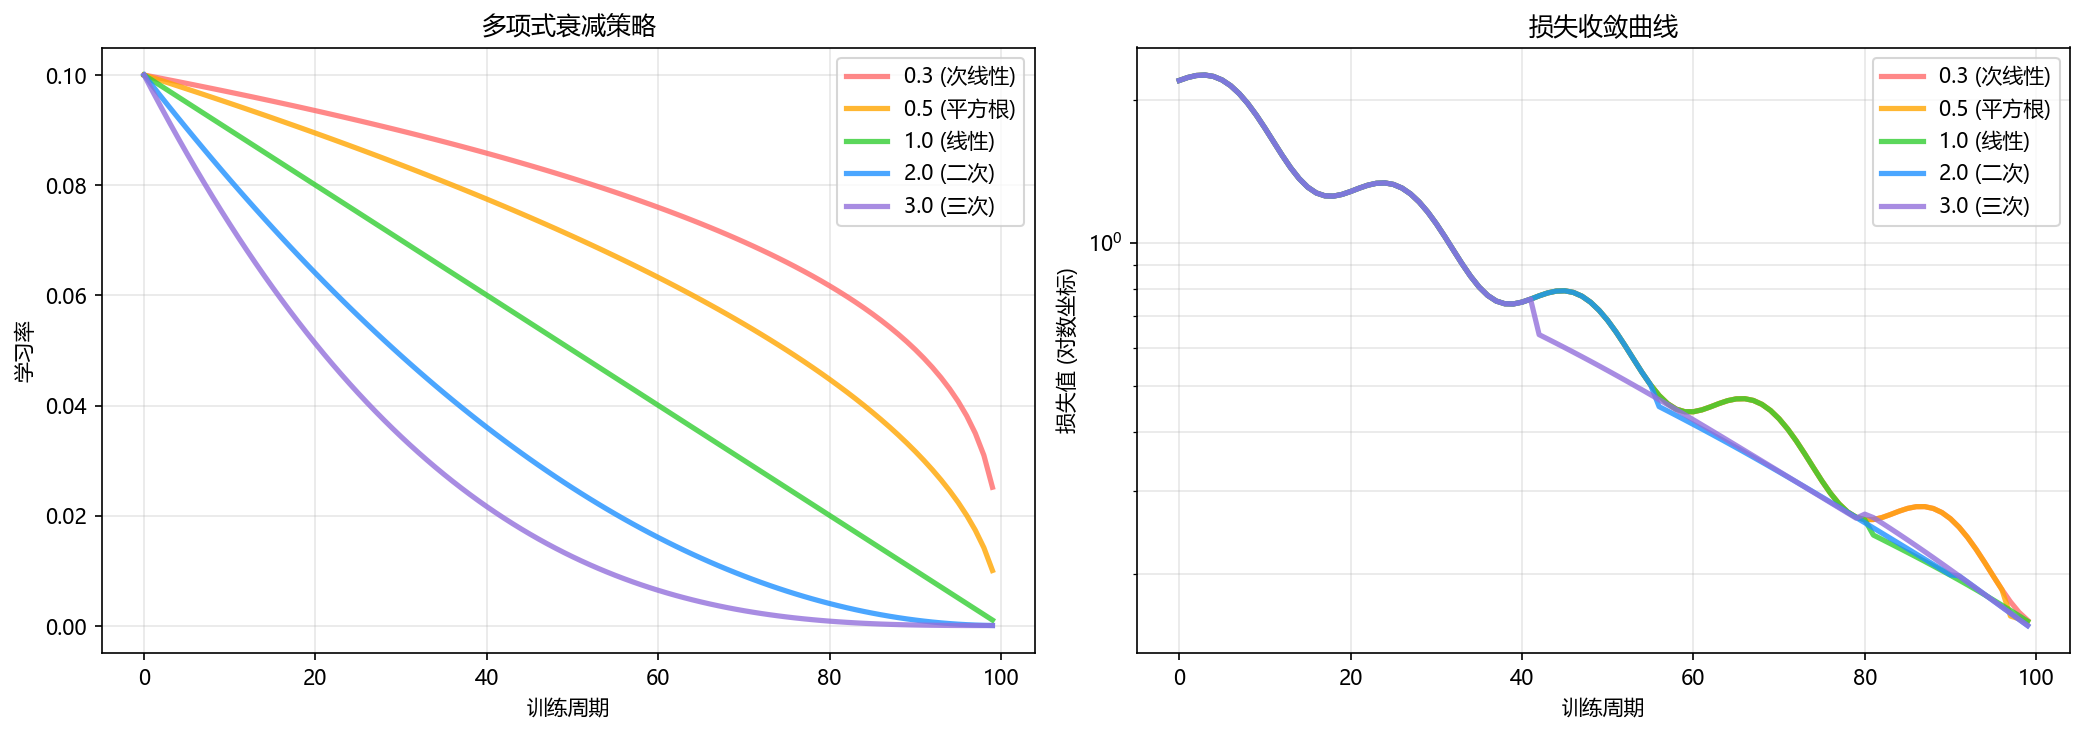

In [31]:
# 参数设置
initial_lr = 0.1
epochs = np.arange(100)

# 多项式衰减函数
def polynomial_decay(epoch, power=1.0, total_epochs=100, end_factor=0.001):
    if epoch >= total_epochs:
        return initial_lr * end_factor
    decay_factor = (1 - epoch / total_epochs) ** power
    lr = initial_lr * (end_factor + (1 - end_factor) * decay_factor)
    return lr

# 不同幂次值
powers = [0.3, 0.5, 1.0, 2.0, 3.0]
power_names = ['0.3 (次线性)', '0.5 (平方根)', '1.0 (线性)', '2.0 (二次)', '3.0 (三次)']
colors = ['#FF6B6B', '#FFA500', '#32CD32', '#1E90FF', '#9370DB']

# 模拟损失函数
def simulate_loss(lr_vals):
    losses = []
    base_loss = 2.0

    for i, (epoch, lr) in enumerate(zip(epochs, lr_vals)):
        base_decay = np.exp(-epoch * 0.025)

        if lr > 0.02:
            lr_penalty = 1.1 + 0.15 * np.sin(epoch * 0.3)
        elif lr > 0.001:
            lr_penalty = 0.85 + 0.1 * np.exp(-(lr - 0.005)**2 / 0.0005)
        else:
            lr_penalty = 0.95 + 0.05 * np.sin(epoch * 0.1)

        current_loss = base_loss * base_decay * lr_penalty

        if i > 0:
            current_loss = min(current_loss, losses[-1] * 1.02)

        losses.append(max(current_loss, 0.01))

    return np.array(losses)

# 创建图表
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 左图：不同幂次的多项式衰减策略
for p, p_name, color in zip(powers, power_names, colors):
    lr_vals = [polynomial_decay(e, power=p) for e in epochs]
    axes[0].plot(epochs, lr_vals, linewidth=2.5, alpha=0.8,
                label=p_name, color=color)

axes[0].set_xlabel('训练周期')
axes[0].set_ylabel('学习率')
axes[0].set_title('多项式衰减策略')
axes[0].grid(True, alpha=0.3)
axes[0].legend(loc='upper right')

# 右图：对应的损失收敛曲线
for p, p_name, color in zip(powers, power_names, colors):
    lr_vals = [polynomial_decay(e, power=p) for e in epochs]
    losses = simulate_loss(lr_vals)
    axes[1].semilogy(epochs, losses, linewidth=2.5, alpha=0.8,
                    label=p_name, color=color)

axes[1].set_xlabel('训练周期')
axes[1].set_ylabel('损失值 (对数坐标)')
axes[1].set_title('损失收敛曲线')
axes[1].grid(True, alpha=0.3, which='both')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.show()

### 凸目标的收敛性分析
- 凸优化的收敛性分析核心在于：目标函数的性质（凸性、光滑性、强凸性）直接决定了优化算法可达到的理论收敛速度。 对于光滑凸函数，经典梯度下降法能以$O(1/k)$的次线性速度收敛；如果函数还具有强凸性，则可获得更快的线性收敛$O(\gamma^k)$。理论上的重大突破是，$Nesterov$加速梯度法通过引入动量，将光滑凸问题的收敛率提升至最优的$O(1/k^2)$。这些分析一般通过建立单步下降引理、构造$Lyapunov$函数并求解递归不等式来完成。

## 小批量随机梯度下降
- 向量化和缓存的一些影响：就按照局部性原理来理解这个地方，逐元素计算最差、其次是逐列计算，最好是一次性计算。

In [4]:
import time

# 准备数据
A = torch.zeros(256, 256)
B = torch.randn(256, 256)
C = torch.randn(256, 256)

# 计时函数
def time_method(method_name, func):
    start = time.time()
    func()
    elapsed = time.time() - start
    print(f"{method_name}: {elapsed:.4f} 秒")
    return elapsed

# 三种计算方法
times = []

# 方法1：逐元素计算
elapsed = time_method("逐元素计算", lambda: [
    [torch.dot(B[i, :], C[:, j]) for j in range(256)] for i in range(256)
])
times.append(elapsed)

# 方法2：逐列计算
A = torch.zeros(256, 256)
elapsed = time_method("逐列计算", lambda: [
    A[:, j].copy_(torch.mv(B, C[:, j])) for j in range(256)
])
times.append(elapsed)

# 方法3：一次性计算
A = torch.zeros(256, 256)
elapsed = time_method("一次性计算", lambda: torch.mm(B, C))
times.append(elapsed)

# 计算Gigaflops
flops = 2 * 256**3  # 256x256矩阵乘法的浮点运算次数
gigaflops = [flops / (t * 1e9) for t in times]

print(f"\n性能对比:")
print(f"逐元素: {gigaflops[0]:.3f} Gflops")
print(f"逐列: {gigaflops[1]:.3f} Gflops")
print(f"全矩阵: {gigaflops[2]:.3f} Gflops")

逐元素计算: 0.7252 秒
逐列计算: 0.0080 秒
一次性计算: 0.0010 秒

性能对比:
逐元素: 0.046 Gflops
逐列: 4.193 Gflops
全矩阵: 33.549 Gflops


开始训练不同配置的SGD模型...

1. 批量梯度下降 (batch_size=1500)
Epoch 1/10, Loss: 0.2752, Time: 0.092s
Epoch 2/10, Loss: 0.2497, Time: 0.108s
Epoch 3/10, Loss: 0.2458, Time: 0.023s
Epoch 4/10, Loss: 0.2447, Time: 0.022s
Epoch 5/10, Loss: 0.2442, Time: 0.026s
Epoch 6/10, Loss: 0.2440, Time: 0.023s
Epoch 7/10, Loss: 0.2440, Time: 0.022s
Epoch 8/10, Loss: 0.2441, Time: 0.023s
Epoch 9/10, Loss: 0.2444, Time: 0.022s
Epoch 10/10, Loss: 0.2448, Time: 0.025s
Average time per epoch: 0.039 sec
Final loss: 0.245

2. 随机梯度下降 (batch_size=1)
Epoch 1/10, Loss: 0.2459, Time: 0.741s
Epoch 2/10, Loss: 0.2510, Time: 0.695s
Epoch 3/10, Loss: 0.2527, Time: 0.694s
Epoch 4/10, Loss: 0.2458, Time: 0.681s
Epoch 5/10, Loss: 0.2428, Time: 0.696s
Epoch 6/10, Loss: 0.2468, Time: 0.673s
Epoch 7/10, Loss: 0.2454, Time: 0.657s
Epoch 8/10, Loss: 0.2445, Time: 0.667s
Epoch 9/10, Loss: 0.2451, Time: 0.658s
Epoch 10/10, Loss: 0.2457, Time: 0.661s
Average time per epoch: 0.682 sec
Final loss: 0.246

3. 小批量梯度下降 (batch_size=100)
Epoch 1/10, 

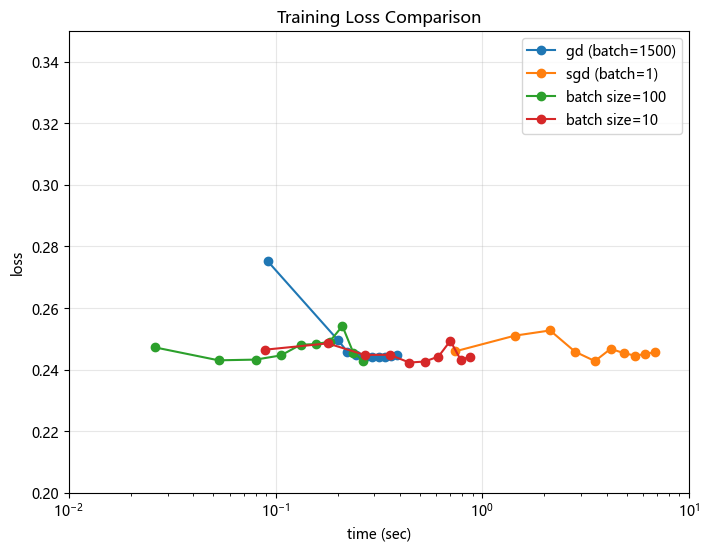


最终性能对比:
gd (batch=1500): 最终损失=0.2448, 平均每轮时间=0.039s
sgd (batch=1): 最终损失=0.2457, 平均每轮时间=0.682s
batch size=100: 最终损失=0.2428, 平均每轮时间=0.027s
batch size=10: 最终损失=0.2442, 平均每轮时间=0.087s


In [5]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import urllib.request
import os

# ====================== 1. 数据准备部分 ======================

def download_airfoil_data(url, save_path):
    """下载数据文件"""
    if not os.path.exists(save_path):
        print(f"正在下载数据到 {save_path}...")
        urllib.request.urlretrieve(url, save_path)
        print("下载完成!")
    return save_path

def get_data_ch11(batch_size=10, n=1500):
    """
    加载和预处理翼型数据集
    """
    # 数据集URL
    data_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00291/airfoil_self_noise.dat'
    data_path = '../data/airfoil_self_noise.dat'

    # 下载数据
    data_path = download_airfoil_data(data_url, data_path)

    # 加载数据
    data = np.genfromtxt(data_path, dtype=np.float32, delimiter='\t')

    # 标准化数据
    data_mean = np.mean(data, axis=0)
    data_std = np.std(data, axis=0)
    data_std[data_std == 0] = 1  # 避免除零

    data_normalized = (data - data_mean) / data_std

    # 转换为PyTorch张量
    data_tensor = torch.from_numpy(data_normalized)

    # 分离特征和标签
    features = data_tensor[:n, :-1]  # 前n个样本，所有特征列
    labels = data_tensor[:n, -1].unsqueeze(1)  # 前n个样本，最后一列

    # 创建数据集和数据加载器
    dataset = TensorDataset(features, labels)
    data_iter = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0)

    return data_iter, features.shape[1]

# ====================== 2. 工具函数部分 ======================

class Timer:
    """计时器类"""
    def __init__(self):
        self.times = []
        self.start_time = 0
        self.running = False

    def start(self):
        """开始计时"""
        if not self.running:
            self.start_time = time.time()
            self.running = True
        return self

    def stop(self):
        """停止计时并记录时间"""
        if self.running:
            self.times.append(time.time() - self.start_time)
            self.running = False
        return self.times[-1] if self.times else 0

    def avg(self):
        """计算平均时间"""
        return np.mean(self.times) if self.times else 0

    def cumsum(self):
        """计算累计时间"""
        return np.cumsum(self.times)

    def reset(self):
        """重置计时器"""
        self.times = []
        self.start_time = 0
        self.running = False

def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

def squared_loss(y_hat, y):
    """平方损失函数"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

def evaluate_loss(net, data_iter, loss_fn):
    """评估模型在数据集上的损失"""
    total_loss = 0
    total_samples = 0

    with torch.no_grad():  # 不计算梯度
        for X, y in data_iter:
            y_hat = net(X)
            l = loss_fn(y_hat, y).sum()
            total_loss += l.item()
            total_samples += y.shape[0]

    return total_loss / total_samples if total_samples > 0 else 0

# ====================== 3. 优化器部分 ======================

def sgd(params, states, hyperparams):
    """随机梯度下降优化器"""
    for p in params:
        if p.grad is not None:
            p.data.sub_(hyperparams['lr'] * p.grad)
            p.grad.data.zero_()

# ====================== 4. 训练函数部分 ======================

def train_ch11(trainer_fn, states, hyperparams, data_iter, feature_dim, num_epochs=2):
    """
    训练函数

    参数:
    trainer_fn: 优化器函数
    states: 优化器状态（这里未使用，保持接口一致）
    hyperparams: 超参数（如学习率）
    data_iter: 数据迭代器
    feature_dim: 特征维度
    num_epochs: 训练轮数
    """
    # 初始化模型参数
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)

    # 定义模型和损失函数
    def net(X):
        return linreg(X, w, b)

    # 记录损失
    losses = []
    epoch_times = []

    # 训练模型
    timer = Timer()
    n = 0

    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        epoch_loss = 0
        batch_count = 0

        for X, y in data_iter:
            timer.start()

            # 前向传播
            l = squared_loss(net(X), y).mean()

            # 反向传播
            l.backward()

            # 参数更新
            trainer_fn([w, b], states, hyperparams)

            timer.stop()

            n += X.shape[0]
            epoch_loss += l.item()
            batch_count += 1

            # 每200个样本记录一次（可选）
            if n % 200 == 0:
                pass  # 这里可以选择记录中间损失

        # 计算本轮平均损失
        avg_loss = evaluate_loss(net, data_iter, squared_loss)
        losses.append(avg_loss)

        # 记录本轮时间
        epoch_time = time.time() - epoch_start_time
        epoch_times.append(epoch_time)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Time: {epoch_time:.3f}s')

    # 计算平均每轮时间
    avg_time_per_epoch = np.mean(epoch_times)
    print(f'Average time per epoch: {avg_time_per_epoch:.3f} sec')
    print(f'Final loss: {losses[-1]:.3f}')

    return (epoch_times, losses)

def train_sgd(lr, batch_size, num_epochs=2):
    """训练SGD模型"""
    data_iter, feature_dim = get_data_ch11(batch_size)
    return train_ch11(sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

# ====================== 5. 绘图函数 ======================

def plot_results(results, labels, xlabel='time (sec)', ylabel='loss', xlim=[1e-2, 10], title='Training Loss Comparison'):
    """
    绘制训练结果

    参数:
    results: 结果列表，每个元素是(time, loss)元组
    labels: 每个结果的标签
    """
    plt.figure(figsize=(8, 6))

    for (times, losses), label in zip(results, labels):
        # 计算累计时间
        cum_times = np.cumsum(times)

        # 对于每个epoch，我们取一个时间点
        # 这里简单处理：将每个epoch的时间累加，对应每个epoch的损失
        if len(cum_times) > 0 and len(losses) > 0:
            # 确保时间点数量与损失值数量一致
            min_len = min(len(cum_times), len(losses))
            plt.plot(cum_times[:min_len], losses[:min_len], marker='o', label=label)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(xlim)
    plt.ylim([0.2, 0.35])  # 根据原始代码的y轴范围
    plt.xscale('log')  # x轴使用对数尺度
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# ====================== 6. 主程序 ======================

if __name__ == "__main__":
    print("开始训练不同配置的SGD模型...")
    print("=" * 50)

    # 训练不同配置的模型
    print("\n1. 批量梯度下降 (batch_size=1500)")
    gd_res = train_sgd(1, 1500, 10)

    print("\n2. 随机梯度下降 (batch_size=1)")
    sgd_res = train_sgd(0.005, 1, 10)

    print("\n3. 小批量梯度下降 (batch_size=100)")
    mini1_res = train_sgd(0.4, 100, 10)

    print("\n4. 小批量梯度下降 (batch_size=10)")
    mini2_res = train_sgd(0.05, 10, 10)

    print("\n" + "=" * 50)
    print("训练完成，开始绘制结果...")

    # 绘制结果
    results = [gd_res, sgd_res, mini1_res, mini2_res]
    labels = ['gd (batch=1500)', 'sgd (batch=1)', 'batch size=100', 'batch size=10']

    plot_results(results, labels)

    # 额外：显示每个配置的最终性能
    print("\n最终性能对比:")
    for (times, losses), label in zip(results, labels):
        avg_time = np.mean(times)
        final_loss = losses[-1] if losses else float('inf')
        print(f"{label}: 最终损失={final_loss:.4f}, 平均每轮时间={avg_time:.3f}s")

loss: 0.242, 0.008 sec/epoch


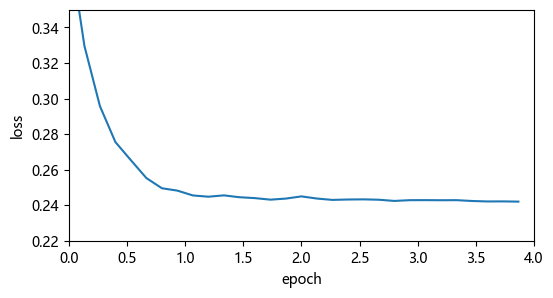

In [5]:
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    """简洁版本训练函数"""
    # 初始化模型
    net = nn.Sequential(nn.Linear(5, 1))

    # 初始化权重
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.normal_(m.weight, std=0.01)

    net.apply(init_weights)

    # 创建优化器
    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')

    # 记录训练过程
    losses = []
    n, timer = 0, Timer()

    for epoch in range(num_epochs):
        for X, y in data_iter:
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()

            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                current_loss = evaluate_loss(net, data_iter, loss) / 2
                losses.append(current_loss)
                timer.start()

    print(f'loss: {losses[-1]:.3f}, {timer.avg():.3f} sec/epoch')

    # 绘图
    plt.figure(figsize=(6, 3))
    x_points = [i * 200 / len(next(iter(data_iter))[0]) / len(data_iter)
                for i in range(len(losses))]
    plt.plot(x_points, losses)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.xlim([0, num_epochs])
    plt.ylim([0.22, 0.35])
    plt.show()

# 使用示例
data_iter, _ = get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

## 动量法
- 就是引入一个速度变量$\mathrm{v}$，其更新方式为$\mathrm{v=\beta * v - \eta * g}$，这里的$\mathrm{v}$是速度（动量向量）、$\mathrm{\beta}$是动量系数（越大惯性越强记忆历史越久，通常为$0.9$或$0.99$）、$\mathrm{\eta}$是学习率、$\mathrm{g}$是当前梯度，参数更新的方式就是$\mathrm{\theta=\theta+v}$
- 在一致方向：梯度方向持续不变或相似时，动量会不断累积，更新幅度越来越大，实现加速。
- 在振荡方向：梯度方向频繁正负交替时（如峡谷地形），动量项会相互抵消，从而减弱振荡，使更新更倾向于沿着峡谷的主轴方向（即最小值方向）进行。
### 条件不佳问题
- 就是目标函数在不同方向上的曲率差异极大，导致优化算法收敛缓慢、难以找到最优解。

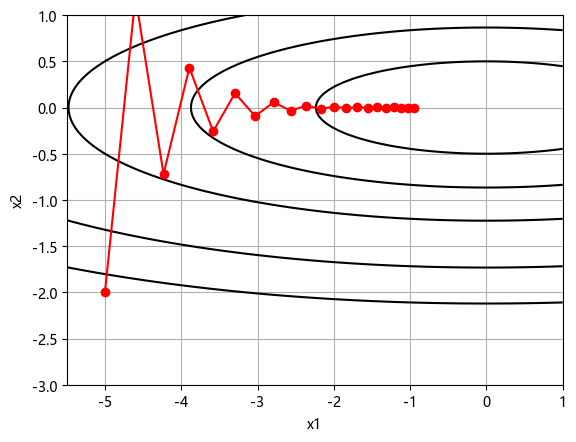

In [7]:
eta = 0.4

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

def gd_2d(x1, x2, s1, s2):
    return x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0

# 模拟训练过程
def train_2d(trainer, steps=20):
    x1, x2, s1, s2 = -5, -2, 0, 0
    results = [(x1, x2)]
    for i in range(steps):
        x1, x2, s1, s2 = trainer(x1, x2, s1, s2)
        results.append((x1, x2))
    return results

# 绘制结果
def show_trace_2d(f, results):
    # 创建网格数据
    x1 = np.linspace(-5.5, 1.0, 100)
    x2 = np.linspace(-3.0, 1.0, 100)
    X1, X2 = np.meshgrid(x1, x2)
    Z = f(X1, X2)

    # 绘制等高线
    plt.contour(X1, X2, Z, colors='black', levels=[0.5, 1.5, 3, 6, 9])

    # 绘制轨迹
    results = np.array(results)
    plt.plot(results[:, 0], results[:, 1], '-o', color='red')

    # 设置坐标轴
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.xlim(-5.5, 1.0)
    plt.ylim(-3.0, 1.0)
    plt.grid(True)
    plt.show()

# 执行训练和绘图
results = train_2d(gd_2d)
show_trace_2d(f_2d, results)

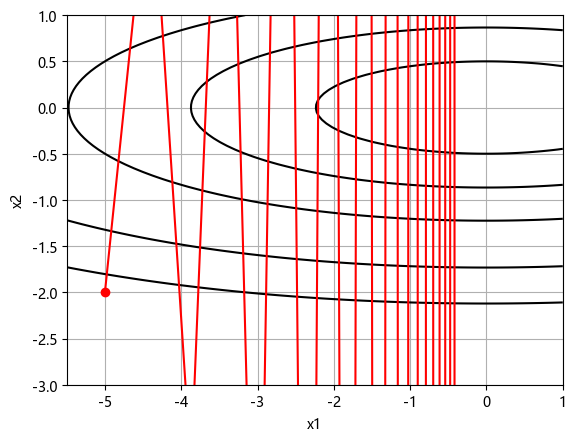

In [8]:
eta = 0.6
results = train_2d(gd_2d)
show_trace_2d(f_2d, results)

- 动量法的效果：

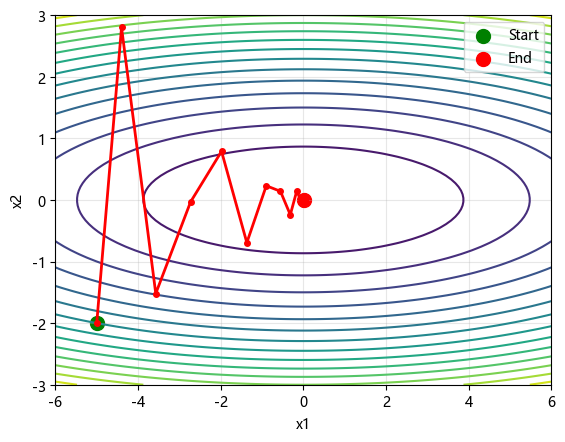

In [3]:
# 定义目标函数
def f_2d(x1, x2):
    return 0.1 * x1**2 + 2 * x2**2

# 动量法更新函数
def momentum_2d(x1, x2, v1, v2, eta=0.6, beta=0.5):
    v1 = beta * v1 + 0.2 * x1
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

# 训练函数
def train_2d(optimizer, steps=20, x1=-5, x2=-2):
    results = [(x1, x2)]
    v1, v2 = 0, 0

    for i in range(steps):
        x1, x2, v1, v2 = optimizer(x1, x2, v1, v2)
        results.append((x1, x2))

    return results

# 可视化函数
def show_trace_2d(f, trajectory):
    # 绘制等高线
    x1 = np.linspace(-6, 6, 100)
    x2 = np.linspace(-3, 3, 100)
    X1, X2 = np.meshgrid(x1, x2)
    Z = f(X1, X2)

    plt.contour(X1, X2, Z, levels=20, cmap='viridis')

    # 绘制优化路径
    x1_vals, x2_vals = zip(*trajectory)
    plt.plot(x1_vals, x2_vals, 'r-o', linewidth=2, markersize=4)
    plt.scatter([x1_vals[0]], [x2_vals[0]], color='green', s=100, label='Start')
    plt.scatter([x1_vals[-1]], [x2_vals[-1]], color='red', s=100, label='End')

    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 主程序
eta, beta = 0.6, 0.5
trajectory = train_2d(lambda x1, x2, v1, v2: momentum_2d(x1, x2, v1, v2, eta, beta))
show_trace_2d(f_2d, trajectory)

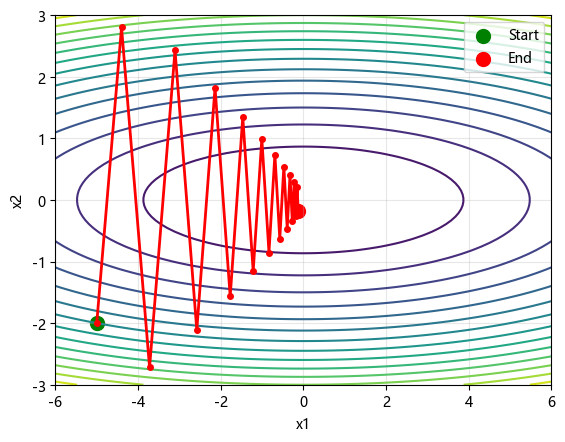

In [4]:
eta, beta = 0.6, 0.25
trajectory = train_2d(lambda x1, x2, v1, v2: momentum_2d(x1, x2, v1, v2, eta, beta))
show_trace_2d(f_2d, trajectory)

- 有限样本权重：就是动量法在一开始由于初始速度为零的原因，会大大的低估当时的梯度，所以在计算出$v$之后，对它施加一个修正权重$\frac{1}{1-\beta^t}$，其中$t$是时间步，这样在开始的时候修正因子会放大梯度估计，使其更接近真实的梯度，但是随后训练的时间步增加，这个修正因子会越发接近$1$，从而使修正效果逐渐消失（实际中很多情况下可以省略这个修正，或者调整学习率调度来达到类似效果）

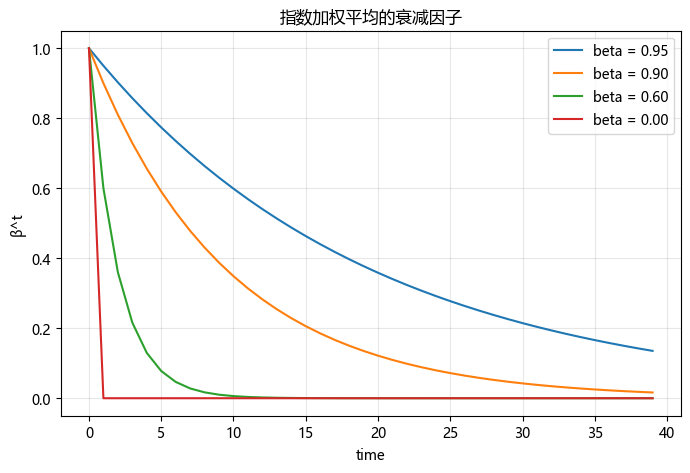

In [5]:
# 设置图形大小
plt.figure(figsize=(8, 5))

# 不同beta值
betas = [0.95, 0.9, 0.6, 0]

# 生成曲线
x = np.arange(40)
for beta in betas:
    plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')

plt.xlabel('time')
plt.ylabel('β^t')
plt.title('指数加权平均的衰减因子')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Training with lr=0.02, momentum=0.5
--------------------------------------------------
Epoch 1/20, Loss: 0.000101
Epoch 2/20, Loss: 0.000100
Epoch 3/20, Loss: 0.000101
Epoch 4/20, Loss: 0.000100
Epoch 5/20, Loss: 0.000102
Epoch 6/20, Loss: 0.000100
Epoch 7/20, Loss: 0.000100
Epoch 8/20, Loss: 0.000101
Epoch 9/20, Loss: 0.000103
Epoch 10/20, Loss: 0.000102
Epoch 11/20, Loss: 0.000100
Epoch 12/20, Loss: 0.000101
Epoch 13/20, Loss: 0.000103
Epoch 14/20, Loss: 0.000100
Epoch 15/20, Loss: 0.000103
Epoch 16/20, Loss: 0.000100
Epoch 17/20, Loss: 0.000100
Epoch 18/20, Loss: 0.000103
Epoch 19/20, Loss: 0.000100
Epoch 20/20, Loss: 0.000100
Training with lr=0.01, momentum=0.9
--------------------------------------------------
Epoch 1/20, Loss: 0.001301
Epoch 2/20, Loss: 0.000100
Epoch 3/20, Loss: 0.000103
Epoch 4/20, Loss: 0.000106
Epoch 5/20, Loss: 0.000101
Epoch 6/20, Loss: 0.000101
Epoch 7/20, Loss: 0.000110
Epoch 8/20, Loss: 0.000103
Epoch 9/20, Loss: 0.000101
Epoch 10/20, Loss: 0.000105
Epoc

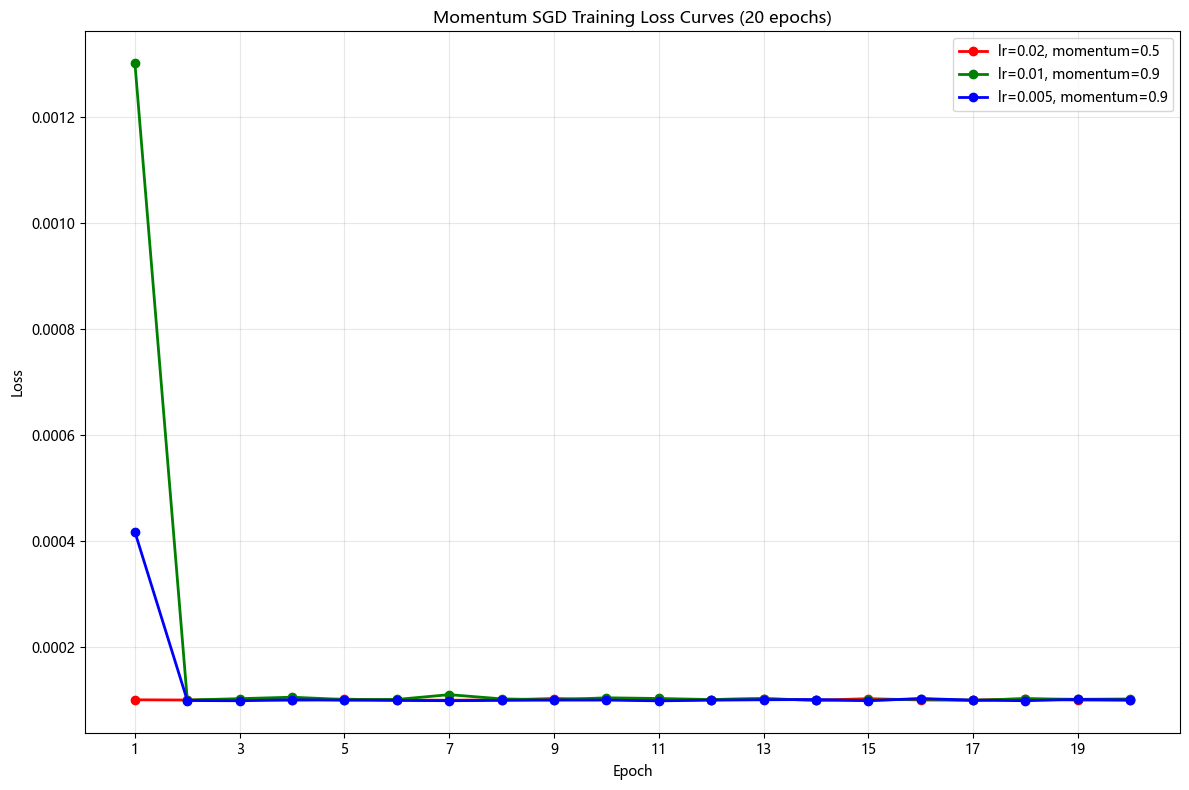

In [9]:
# 1. 初始化动量状态函数
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

# 2. 动量SGD更新函数
def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

# 3. 生成数据函数
def get_data_ch11(batch_size=10, n=1000):
    """生成线性回归数据"""
    # 真实参数
    true_w = torch.tensor([2.0, -3.4])
    true_b = torch.tensor([4.2])

    # 生成特征
    features = torch.randn(n, 2)
    # 生成标签（带噪声）
    labels = torch.matmul(features, true_w.reshape(-1, 1)) + true_b
    labels += torch.randn(n, 1) * 0.01

    # 创建数据加载器
    dataset = TensorDataset(features, labels)
    data_iter = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return data_iter, features.shape[1]

# 4. 训练函数
def train_ch11(optimizer_fn, states, hyperparams, data_iter, feature_dim, num_epochs=2):
    """训练线性回归模型"""
    # 初始化参数
    w = torch.normal(0, 0.01, size=(feature_dim, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)

    # 损失函数
    loss_fn = nn.MSELoss()

    # 记录损失
    train_loss = []
    epochs = []

    for epoch in range(num_epochs):
        for X, y in data_iter:
            # 前向传播
            y_hat = torch.matmul(X, w) + b
            loss = loss_fn(y_hat, y)

            # 反向传播
            loss.backward()

            # 更新参数
            optimizer_fn([w, b], states, hyperparams)

        # 计算当前epoch的平均损失
        with torch.no_grad():
            total_loss = 0
            count = 0
            for X, y in data_iter:
                y_hat = torch.matmul(X, w) + b
                total_loss += loss_fn(y_hat, y).item()
                count += 1
            avg_loss = total_loss / count if count > 0 else 0

        train_loss.append(avg_loss)
        epochs.append(epoch + 1)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}')

    return train_loss, epochs

# 修改主训练函数，增加训练轮次
def train_momentum(lr, momentum, num_epochs=20):  # 改为20个epoch
    """使用不同参数训练动量法"""
    print(f"Training with lr={lr}, momentum={momentum}")
    print("-" * 50)

    # 获取数据
    data_iter, feature_dim = get_data_ch11(batch_size=10)

    # 初始化动量状态
    states = init_momentum_states(feature_dim)

    # 超参数
    hyperparams = {'lr': lr, 'momentum': momentum}

    # 训练
    train_loss, epochs = train_ch11(
        sgd_momentum, states, hyperparams,
        data_iter, feature_dim, num_epochs
    )

    return train_loss, epochs

# 运行不同参数的训练
# 设置随机种子保证可重复性
torch.manual_seed(42)

# 存储结果
results = []

# 第一组参数
loss1, epochs1 = train_momentum(0.02, 0.5, num_epochs=20)
results.append(('lr=0.02, momentum=0.5', loss1))

# 第二组参数
loss2, epochs2 = train_momentum(0.01, 0.9, num_epochs=20)
results.append(('lr=0.01, momentum=0.9', loss2))

# 第三组参数
loss3, epochs3 = train_momentum(0.005, 0.9, num_epochs=20)
results.append(('lr=0.005, momentum=0.9', loss3))

# 可视化结果
plt.figure(figsize=(12, 8))

colors = ['r', 'g', 'b']
for i, (label, loss) in enumerate(results):
    plt.plot(range(1, len(loss) + 1), loss,
            color=colors[i], marker='o',
            linewidth=2, label=label, markersize=6)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Momentum SGD Training Loss Curves (20 epochs)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(1, 21, 2))  # 设置x轴刻度，每2个epoch显示一个刻度
plt.tight_layout()
plt.show()

Epoch 1/10, Loss: 8.529114
Epoch 2/10, Loss: 0.001632
Epoch 3/10, Loss: 0.000534
Epoch 4/10, Loss: 0.000537
Epoch 5/10, Loss: 0.000527
Epoch 6/10, Loss: 0.000542
Epoch 7/10, Loss: 0.000539
Epoch 8/10, Loss: 0.000547
Epoch 9/10, Loss: 0.000540
Epoch 10/10, Loss: 0.000542


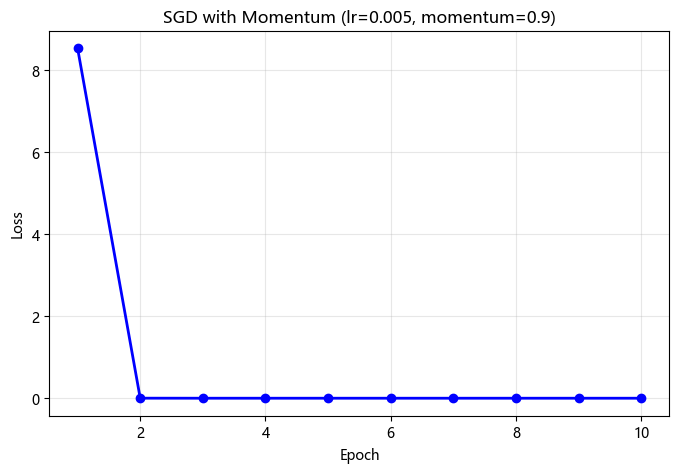

In [10]:
# 1. 生成数据
def get_data_ch11(batch_size=10, n=1000):
    true_w = torch.tensor([2.0, -3.4])
    true_b = torch.tensor([4.2])

    features = torch.randn(n, 2)
    labels = torch.matmul(features, true_w.reshape(-1, 1)) + true_b
    labels += torch.randn(n, 1) * 0.01

    dataset = TensorDataset(features, labels)
    data_iter = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return data_iter, features.shape[1]

# 2. 简洁训练函数
def train_concise_ch11(trainer, hyperparams, data_iter, num_epochs=4):
    # 模型参数
    w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)

    # 定义模型和损失
    def linreg(X, w, b):
        return torch.matmul(X, w) + b

    def squared_loss(y_hat, y):
        return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

    # 优化器
    net_params = [w, b]
    optimizer = trainer(net_params, **hyperparams)

    # 训练
    losses = []
    for epoch in range(num_epochs):
        epoch_loss = 0
        batch_count = 0

        for X, y in data_iter:
            l = squared_loss(linreg(X, w, b), y).sum()
            l.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss += l.item()
            batch_count += 1

        avg_loss = epoch_loss / batch_count
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.6f}')

    return losses

# 3. 主程序
torch.manual_seed(42)
data_iter, _ = get_data_ch11(batch_size=10)

# 使用PyTorch SGD优化器
trainer = torch.optim.SGD
hyperparams = {'lr': 0.005, 'momentum': 0.9}

losses = train_concise_ch11(trainer, hyperparams, data_iter, num_epochs=10)

# 4. 可视化
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(losses)+1), losses, 'b-o', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('SGD with Momentum (lr=0.005, momentum=0.9)')
plt.grid(True, alpha=0.3)
plt.show()

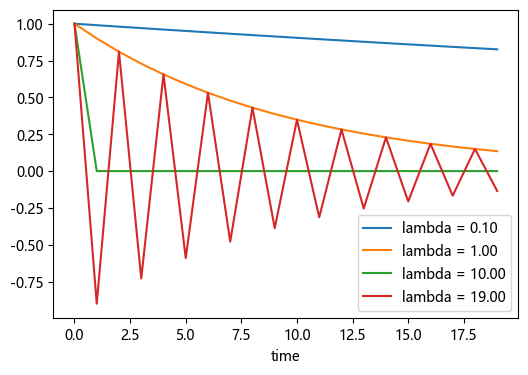

In [3]:
lambdas = [0.1, 1, 10, 19]
eta = 0.1

plt.figure(figsize=(6, 4))
t = torch.arange(20).detach().numpy()

for lam in lambdas:
    plt.plot(t, (1 - eta * lam) ** t, label=f'lambda = {lam:.2f}')

plt.xlabel('time')
plt.legend()
plt.show()

## $\mathrm{AdaGrad}$ 算法
- 算法提出的原因（解决的问题）：标准的随机梯度下降所有参数共享同意的学习率，但是实际上不同参数的重要性是不同的、其梯度尺度差异巨大，此外还有稀疏特征需要特殊处理，而且统一全局学习率可能导致收敛缓慢或不稳定，所以这种传统的学习率设置是不科学的。
- 核心思想：对于频繁出现的特征，给与较小的学习率，对于不频繁出现的特征，给予较大的学习率。
$$\theta_{t+1}=\theta_t-\frac{\eta}{\sqrt{G_t+\epsilon}}\odot g_t$$
- 上述就是参数更新公式，其中$\eta$是初始学习率（全局），$g_t$是时间步$t$的梯度，$\epsilon$是防止除零的极小常数，$G_t$是梯度平方的累计矩阵（从梯度下降开始开始算）。
- 所以从整体来看对于每个参数的学习率就变成了:
$$\eta_{t,i}=\frac{\eta}{\sqrt{\sum^t_{\tau=1}g^2_{tau,i}+\epsilon}}$$
- 所以整体学习率的变化就是：
    - 在梯度小的位置$\rightarrow$累积平方和小$\rightarrow$学习率大$\rightarrow$移动速度快；
    - 在梯度大的位置$\rightarrow$累积平方和大$\rightarrow$学习率小$\rightarrow$移动速度慢；
- 所以显然这种方法适合稀疏数据学习；但是存在累积偏差问题（早期梯度可能已经过时），存储也是问题，累计梯度平方和单调递增的情况可能造成在非凸问题中可能过早停止。

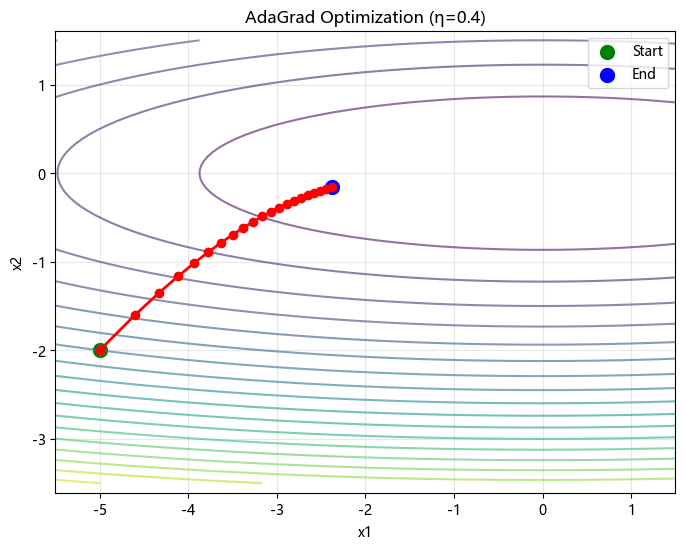


Optimization trajectory with η=0.4:
Step 0: x1=-5.0000, x2=-2.0000
Step 1: x1=-4.6000, x2=-1.6000
Step 2: x1=-4.3292, x2=-1.3501
Step 3: x1=-4.1142, x2=-1.1636
Step 4: x1=-3.9323, x2=-1.0144
Step 5: x1=-3.7728, x2=-0.8908
Step 6: x1=-3.6299, x2=-0.7860
Step 7: x1=-3.4999, x2=-0.6959
Step 8: x1=-3.3803, x2=-0.6176
Step 9: x1=-3.2693, x2=-0.5492
Step 10: x1=-3.1656, x2=-0.4891
Step 11: x1=-3.0682, x2=-0.4360
Step 12: x1=-2.9764, x2=-0.3890
Step 13: x1=-2.8894, x2=-0.3473
Step 14: x1=-2.8068, x2=-0.3103
Step 15: x1=-2.7281, x2=-0.2773
Step 16: x1=-2.6530, x2=-0.2478
Step 17: x1=-2.5811, x2=-0.2216
Step 18: x1=-2.5122, x2=-0.1982
Step 19: x1=-2.4461, x2=-0.1773
Step 20: x1=-2.3826, x2=-0.1586


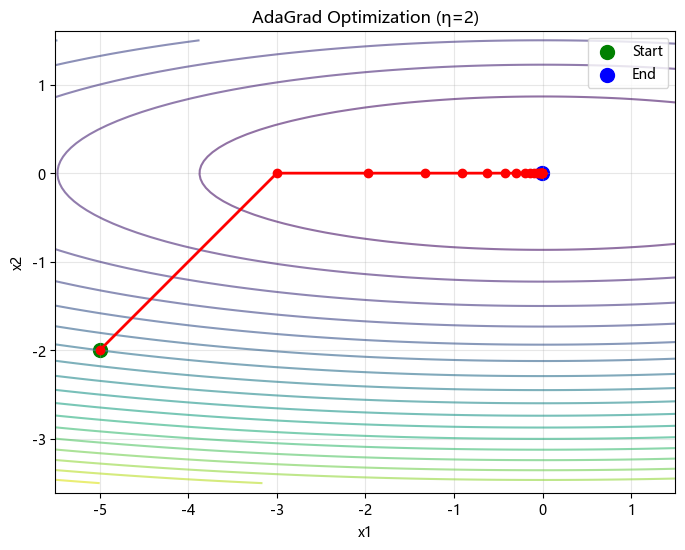


Optimization trajectory with η=2:
Step 0: x1=-5.0000, x2=-2.0000
Step 1: x1=-3.0000, x2=-0.0000
Step 2: x1=-1.9710, x2=-0.0000
Step 3: x1=-1.3306, x2=-0.0000
Step 4: x1=-0.9080, x2=-0.0000
Step 5: x1=-0.6226, x2=-0.0000
Step 6: x1=-0.4278, x2=-0.0000
Step 7: x1=-0.2942, x2=-0.0000
Step 8: x1=-0.2025, x2=-0.0000
Step 9: x1=-0.1394, x2=-0.0000
Step 10: x1=-0.0960, x2=-0.0000
Step 11: x1=-0.0661, x2=-0.0000
Step 12: x1=-0.0455, x2=-0.0000
Step 13: x1=-0.0313, x2=-0.0000
Step 14: x1=-0.0216, x2=-0.0000
Step 15: x1=-0.0148, x2=-0.0000
Step 16: x1=-0.0102, x2=-0.0000
Step 17: x1=-0.0070, x2=-0.0000
Step 18: x1=-0.0048, x2=-0.0000
Step 19: x1=-0.0033, x2=-0.0000
Step 20: x1=-0.0023, x2=-0.0000


In [3]:
import math

# AdaGrad优化函数
def adagrad_2d(x1, x2, s1, s2, eta):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

# 目标函数
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

# 训练并可视化
def visualize_optimization(eta, steps=20, x1=-5, x2=-2):
    # 训练过程
    results = [(x1, x2)]
    s1, s2 = 0, 0

    for i in range(steps):
        x1, x2, s1, s2 = adagrad_2d(x1, x2, s1, s2, eta)
        results.append((x1, x2))

    # 可视化
    results = np.array(results)

    # 生成网格
    X1 = np.linspace(-5.5, 1.5, 100)
    X2 = np.linspace(-3.5, 1.5, 100)
    X1_grid, X2_grid = np.meshgrid(X1, X2)
    Z = f_2d(X1_grid, X2_grid)

    # 绘制
    plt.figure(figsize=(8, 6))
    plt.contour(X1_grid, X2_grid, Z, levels=20, alpha=0.6)
    plt.plot(results[:, 0], results[:, 1], 'o-', color='red', linewidth=2)
    plt.scatter(results[0, 0], results[0, 1], color='green', s=100, label='Start')
    plt.scatter(results[-1, 0], results[-1, 1], color='blue', s=100, label='End')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'AdaGrad Optimization (η={eta})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.axis('equal')
    plt.show()

    # 打印轨迹
    print(f"\nOptimization trajectory with η={eta}:")
    for i, (x1_val, x2_val) in enumerate(results):
        print(f"Step {i}: x1={x1_val:.4f}, x2={x2_val:.4f}")

# 运行两种不同的学习率
visualize_optimization(eta=0.4)
visualize_optimization(eta=2)

## $\mathrm{RMSProp}$算法
- 这个算法的提出主要也是解决前面那个算法遗留下来的问题。
- 核心的创新是（在前一个算法基础上）：使用指数加权移动平均替代简单的累加，让近期梯度具有更大权重。
- 参数更新方式：
$$v_t=\beta v_{t-1}+(1-\beta)g_t^2$$
$$\theta_{t+1}=\theta_t - \frac{\eta}{v_t+\epsilon}g_t$$
- 这里的$\beta$设置和往常的加权设置差不多一般是$0.99$或$0.9$

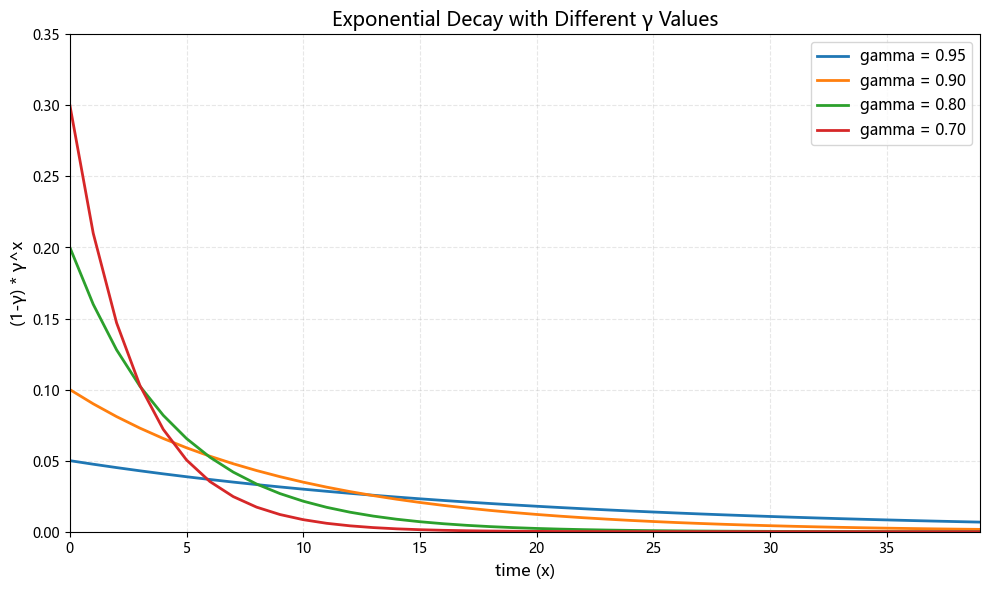

In [4]:
# 设置图形大小
plt.figure(figsize=(10, 6))

# 不同的gamma值
gammas = [0.95, 0.9, 0.8, 0.7]

# 生成x轴数据
x = np.arange(40)

# 为每个gamma值绘制曲线
for gamma in gammas:
    # 计算y值：y = (1 - gamma) * gamma^x
    y = (1 - gamma) * gamma ** x
    # 绘制曲线
    plt.plot(x, y, label=f'gamma = {gamma:.2f}', linewidth=2)

# 添加标签和标题
plt.xlabel('time (x)', fontsize=12)
plt.ylabel('(1-γ) * γ^x', fontsize=12)
plt.title('Exponential Decay with Different γ Values', fontsize=14)

# 添加网格和图例
plt.grid(True, alpha=0.3, linestyle='--')
plt.legend(fontsize=11)

# 设置x轴和y轴范围
plt.xlim(0, 39)
plt.ylim(0, 0.35)

# 添加一些额外的美化
plt.axhline(y=0, color='black', linewidth=0.5, alpha=0.5)
plt.axvline(x=0, color='black', linewidth=0.5, alpha=0.5)

# 显示图形
plt.tight_layout()
plt.show()

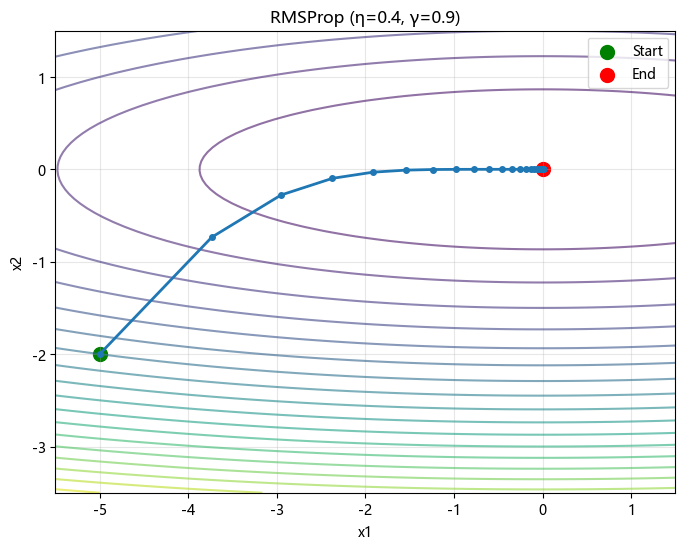

In [5]:
# RMSProp优化函数
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

# 目标函数
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

# 训练并可视化
def visualize_rmsprop(eta_val, gamma_val):
    eta, gamma = eta_val, gamma_val
    x1, x2 = -5, -2
    s1, s2 = 0, 0
    trajectory = [(x1, x2)]

    # 训练过程
    for i in range(50):
        x1, x2, s1, s2 = rmsprop_2d(x1, x2, s1, s2)
        trajectory.append((x1, x2))

    # 可视化
    trajectory = np.array(trajectory)
    X = np.linspace(-5.5, 1.5, 100)
    Y = np.linspace(-3.5, 1.5, 100)
    X, Y = np.meshgrid(X, Y)
    Z = f_2d(X, Y)

    plt.figure(figsize=(8, 6))
    plt.contour(X, Y, Z, levels=20, alpha=0.6)
    plt.plot(trajectory[:, 0], trajectory[:, 1], 'o-', linewidth=2, markersize=4)
    plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', s=100, label='Start')
    plt.scatter(trajectory[-1, 0], trajectory[-1, 1], color='red', s=100, label='End')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'RMSProp (η={eta}, γ={gamma})')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# 运行
eta, gamma = 0.4, 0.9
visualize_rmsprop(eta, gamma)

## $\mathrm{Adadelta}$算法
- 提出这个算法是为了解决$\mathrm{Adagrad}$在学习率上衰减过快的问题。
- 核心思想：使用指数移动平均（$\mathrm{EMA}$）来替代$\mathrm{Adagrad}$中的累计历史梯度平方，同时引入参数更新量$\mathrm{EMA}$来替代固定的学习率（新）。
- 梯度平方的指数移动平均：
$$\mathrm{E}[g^2]_t=\rho\cdot\mathrm{E}[g^2]_{t-1} + (1-\rho)\cdot g_t^2$$
其中$\rho$是衰减率，和前面的那几个算法的含义差不多，只保留最近梯度信息，旧梯度被指数衰减。
- 参数更新：
$$\Delta\theta_t=-\frac{\mathrm{RMS}[\Delta\theta]_{t-1}}{\mathrm{RMS}[g]_t}\cdot g_t$$
其中的$\mathrm{RMS}$的含义是先平方再求平均最后开平方根，$\mathrm{RMS}[g]_t=\sqrt{E[g^2]_t+\epsilon}$（梯度的均方根），$\mathrm{RMS}[\Delta\theta]_{t-1}=\sqrt{E[\Delta\theta^2]_{t-1}+\epsilon}$（历史更新量的均方根）。
$$\theta_{t+1}=\theta_t+\Delta\theta_t$$
- 更新参数的指数移动平均
$$E[\Delta\theta^2]_t=\rho\cdot E[\Delta\theta^2]_{t-1}+(1-\rho)\cdot\Delta\theta_t^2$$
- 没有动量项可能导致收敛比较慢，在局部最优的位置可能不那么好跳出来（因为自适应调整不够激进）。

开始训练...
Epoch 1, Loss: 0.0004
Epoch 2, Loss: 0.0004
Epoch 3, Loss: 0.0004
Epoch 4, Loss: 0.0004
Epoch 5, Loss: 0.0004
Epoch 6, Loss: 0.0003
Epoch 7, Loss: 0.0004
Epoch 8, Loss: 0.0003
Epoch 9, Loss: 0.0004
Epoch 10, Loss: 0.0004

训练完成!
权重 w 的均值: 0.003191
偏置 b: -0.005077


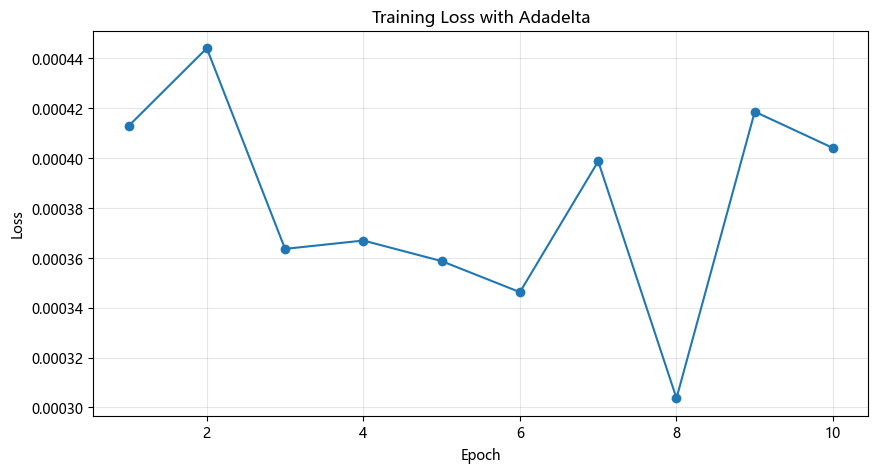

In [9]:
# 1. 生成模拟数据（替代d2l.get_data_ch11）
def get_data(batch_size=10, num_samples=1000, input_dim=20, noise=0.01):
    """生成线性回归的模拟数据"""
    # 真实参数
    true_w = torch.randn(input_dim, 1) * 0.01
    true_b = torch.randn(1) * 0.01

    # 生成特征和标签
    X = torch.randn(num_samples, input_dim)
    y = X @ true_w + true_b + torch.randn(num_samples, 1) * noise

    # 创建数据加载器
    dataset = TensorDataset(X, y)
    data_iter = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return data_iter, input_dim

# 2. Adadelta状态初始化
def init_adadelta_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    delta_w = torch.zeros((feature_dim, 1))
    delta_b = torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

# 3. Adadelta优化算法
def adadelta(params, states, hyperparams):
    rho = hyperparams['rho']
    eps = 1e-5

    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # 更新梯度平方的指数移动平均
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)

            # 计算参数更新
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad

            # 更新参数
            p[:] -= g

            # 更新更新量的指数移动平均
            delta[:] = rho * delta + (1 - rho) * g * g

            # 清零梯度
            p.grad.data.zero_()

# 4. 训练函数（替代d2l.train_ch11）
def train_model(optimizer_fn, init_states_fn, hyperparams, data_iter, feature_dim, num_epochs=10):
    """训练线性回归模型"""
    # 初始化模型参数
    w = torch.normal(0, 0.01, size=(feature_dim, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    params = [w, b]

    # 初始化优化器状态
    states = init_states_fn(feature_dim)

    # 存储损失历史
    train_loss = []

    # 训练循环
    for epoch in range(num_epochs):
        epoch_loss = 0
        batch_count = 0

        for X, y in data_iter:
            # 前向传播
            y_hat = X @ w + b
            loss = ((y_hat - y) ** 2 / 2).mean()

            # 反向传播
            loss.backward()

            # 使用Adadelta更新参数
            optimizer_fn(params, states, hyperparams)

            # 记录损失
            epoch_loss += loss.item()
            batch_count += 1

        # 计算平均损失
        avg_loss = epoch_loss / batch_count
        train_loss.append(avg_loss)
        print(f'Epoch {epoch + 1}, Loss: {avg_loss:.4f}')

    return params, train_loss

# 5. 主程序
# 获取数据
batch_size = 10
data_iter, feature_dim = get_data(batch_size=batch_size)

# 设置超参数
hyperparams = {'rho': 0.9}

# 训练模型
print("开始训练...")
params, train_loss = train_model(
    optimizer_fn=adadelta,
    init_states_fn=init_adadelta_states,
    hyperparams=hyperparams,
    data_iter=data_iter,
    feature_dim=feature_dim,
    num_epochs=10
)

# 提取训练后的参数
w, b = params
print(f"\n训练完成!")
print(f"权重 w 的均值: {w.mean().item():.6f}")
print(f"偏置 b: {b.item():.6f}")

# 可视化训练损失
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_loss) + 1), train_loss, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss with Adadelta')
plt.grid(True, alpha=0.3)
plt.show()

## $\mathrm{Adam}$算法
- 结合了动量法和自适应学习率的算法。
- 核心思想：同时计算
    - 梯度的一阶矩估计（动量）：加速收敛；
    - 梯度的二阶矩估计（自适应学习率）：调整每个参数的学习率；
    - 偏差校正：解决初始化偏差问题；
- 更新规则：
$$\theta_t=\theta_{t-1}-\alpha\cdot\frac{\hat{m}_t}{\sqrt{\hat{v}_t+\epsilon}}$$
其中$\hat{m}_t$是修正后的一阶矩估计（动量项），$\hat{v}_t$是修正后的二阶矩估计（自适应学习率），$\alpha$是学习率；动量的计算（未校正一阶矩）：
$$m_t=\beta_1\cdot m_{t-1}+(1-\beta_1)\cdot g_t$$
其中$\beta_1$是一阶矩衰减率（通常也是$0.9$），计算自适应率（未校正二阶矩）:
$$v_t=\beta_2\cdot v_{t-1}+(1-\beta_2)\cdot g_t^2$$
其中$\beta_2$二阶矩衰减率（通常是$0.999$），偏差校正（主要是为了补偿训练初期两个变量会因初值为$0$而偏向$0$）：
$$\hat{m}_t=\frac{m_t}{1-\beta_1^t}$$
$$\hat{v}_t=\frac{v_t}{1-\beta_2^t}$$

生成数据...
特征维度: 20, 批大小: 10
--------------------------------------------------

1. 使用自定义Adam优化器训练:
Epoch 1/20, Loss: 0.000540
Epoch 2/20, Loss: 0.000408
Epoch 3/20, Loss: 0.000342
Epoch 4/20, Loss: 0.000438
Epoch 5/20, Loss: 0.000698
Epoch 6/20, Loss: 0.000338
Epoch 7/20, Loss: 0.000662
Epoch 8/20, Loss: 0.000486
Epoch 9/20, Loss: 0.000413
Epoch 10/20, Loss: 0.000419
Epoch 11/20, Loss: 0.000386
Epoch 12/20, Loss: 0.000443
Epoch 13/20, Loss: 0.000684
Epoch 14/20, Loss: 0.000735
Epoch 15/20, Loss: 0.000299
Epoch 16/20, Loss: 0.000621
Epoch 17/20, Loss: 0.000386
Epoch 18/20, Loss: 0.000481
Epoch 19/20, Loss: 0.000581
Epoch 20/20, Loss: 0.000887

--------------------------------------------------

2. 使用PyTorch内置Adam优化器训练:
[PyTorch Adam] Epoch 1/20, Loss: 0.000660
[PyTorch Adam] Epoch 2/20, Loss: 0.000193
[PyTorch Adam] Epoch 3/20, Loss: 0.000534
[PyTorch Adam] Epoch 4/20, Loss: 0.000765
[PyTorch Adam] Epoch 5/20, Loss: 0.000404
[PyTorch Adam] Epoch 6/20, Loss: 0.001736
[PyTorch Adam] Epoch 7

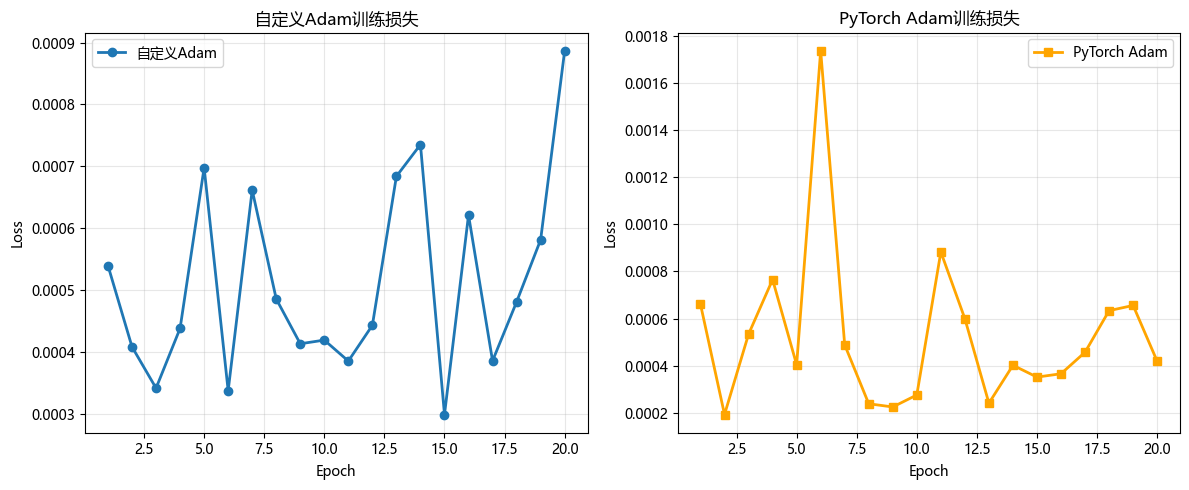


Adam算法参数说明:
  学习率 (lr): 0.01
  beta1 (一阶矩衰减率): 0.9
  beta2 (二阶矩衰减率): 0.999
  epsilon (数值稳定性): 1e-06


In [13]:
# 1. 生成模拟数据
def generate_synthetic_data(batch_size=10, num_samples=1000, input_dim=20):
    """生成线性回归的模拟数据"""
    # 真实参数
    true_w = torch.randn(input_dim, 1) * 0.01
    true_b = torch.randn(1) * 0.01

    # 生成特征和标签
    X = torch.randn(num_samples, input_dim)
    y = X @ true_w + true_b + torch.randn(num_samples, 1) * 0.01

    # 创建数据加载器
    dataset = TensorDataset(X, y)
    data_iter = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    return data_iter, input_dim

# 2. Adam状态初始化
def init_adam_states(feature_dim):
    """初始化Adam状态：一阶矩(v)和二阶矩(s)"""
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

# 3. Adam优化算法实现
def adam(params, states, hyperparams):
    """Adam优化算法"""
    beta1, beta2, eps = 0.9, 0.999, 1e-6

    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            # 更新一阶矩（动量）
            v[:] = beta1 * v + (1 - beta1) * p.grad

            # 更新二阶矩（自适应学习率）
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)

            # 偏差校正
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])

            # 参数更新
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)

            # 清零梯度
            p.grad.data.zero_()

    # 更新时间步
    hyperparams['t'] += 1

# 4. 训练函数（自定义实现）
def train_adam(optimizer_fn, init_states_fn, hyperparams, data_iter, feature_dim, num_epochs=20):
    """训练线性回归模型"""
    # 初始化模型参数
    w = torch.normal(0, 0.01, size=(feature_dim, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    params = [w, b]

    # 初始化优化器状态
    states = init_states_fn(feature_dim)

    # 存储损失历史
    train_loss = []

    # 训练循环
    for epoch in range(num_epochs):
        epoch_loss = 0
        batch_count = 0

        for X, y in data_iter:
            # 前向传播
            y_hat = X @ w + b
            loss = ((y_hat - y) ** 2 / 2).mean()

            # 反向传播
            loss.backward()

            # 使用Adam更新参数
            optimizer_fn(params, states, hyperparams)

            # 记录损失
            epoch_loss += loss.item()
            batch_count += 1

        # 计算平均损失
        avg_loss = epoch_loss / batch_count
        train_loss.append(avg_loss)
        print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.6f}')

    return params, train_loss

# 5. 使用PyTorch内置Adam优化器
def train_with_pytorch_adam(data_iter, feature_dim, lr=0.01, num_epochs=20):
    """使用PyTorch内置Adam优化器训练"""
    # 初始化模型参数
    w = torch.normal(0, 0.01, size=(feature_dim, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)

    # 创建优化器
    optimizer = torch.optim.Adam([w, b], lr=lr)

    # 存储损失历史
    train_loss = []

    # 训练循环
    for epoch in range(num_epochs):
        epoch_loss = 0
        batch_count = 0

        for X, y in data_iter:
            # 前向传播
            y_hat = X @ w + b
            loss = ((y_hat - y) ** 2 / 2).mean()

            # 反向传播
            optimizer.zero_grad()
            loss.backward()

            # 参数更新
            optimizer.step()

            # 记录损失
            epoch_loss += loss.item()
            batch_count += 1

        # 计算平均损失
        avg_loss = epoch_loss / batch_count
        train_loss.append(avg_loss)
        print(f'[PyTorch Adam] Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.6f}')

    return [w, b], train_loss

# 6. 主程序
def main():
    # 设置随机种子，确保结果可复现
    torch.manual_seed(42)
    np.random.seed(42)

    # 生成数据
    print("生成数据...")
    batch_size = 10
    data_iter, feature_dim = generate_synthetic_data(batch_size=batch_size)

    print(f"特征维度: {feature_dim}, 批大小: {batch_size}")
    print("-" * 50)

    # 使用自定义Adam训练
    print("\n1. 使用自定义Adam优化器训练:")
    hyperparams = {'lr': 0.01, 't': 1}
    custom_params, custom_loss = train_adam(
        optimizer_fn=adam,
        init_states_fn=init_adam_states,
        hyperparams=hyperparams,
        data_iter=data_iter,
        feature_dim=feature_dim,
        num_epochs=20
    )

    print("\n" + "-" * 50)

    # 使用PyTorch内置Adam训练（重新生成数据以确保公平比较）
    data_iter, feature_dim = generate_synthetic_data(batch_size=batch_size)

    print("\n2. 使用PyTorch内置Adam优化器训练:")
    pytorch_params, pytorch_loss = train_with_pytorch_adam(
        data_iter=data_iter,
        feature_dim=feature_dim,
        lr=0.01,
        num_epochs=20
    )

    # 比较结果
    print("\n" + "=" * 50)
    print("结果比较:")
    print("=" * 50)

    w_custom, b_custom = custom_params
    w_pt, b_pt = pytorch_params

    print(f"\n自定义Adam - 权重均值: {w_custom.mean().item():.6f}")
    print(f"PyTorch Adam - 权重均值: {w_pt.mean().item():.6f}")

    print(f"\n自定义Adam - 偏置: {b_custom.item():.6f}")
    print(f"PyTorch Adam - 偏置: {b_pt.item():.6f}")

    # 可视化训练损失
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(custom_loss) + 1), custom_loss, marker='o', linewidth=2, label='自定义Adam')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('自定义Adam训练损失')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(pytorch_loss) + 1), pytorch_loss, marker='s', linewidth=2,
             color='orange', label='PyTorch Adam')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('PyTorch Adam训练损失')
    plt.grid(True, alpha=0.3)
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 打印Adam算法参数
    print("\nAdam算法参数说明:")
    print(f"  学习率 (lr): {0.01}")
    print(f"  beta1 (一阶矩衰减率): {0.9}")
    print(f"  beta2 (二阶矩衰减率): {0.999}")
    print(f"  epsilon (数值稳定性): {1e-6}")

main()

| 特性 | Adagrad | RMSprop | Adadelta | Adam |
|------|---------|---------|----------|------|
| 学习率衰减 | 累积导致过快衰减 | 指数衰减 | **完全自适应** | 自适应 |
| 需要初始学习率 | 是 | 是 | **否** | 是 |
| 动量机制 | 无 | 无 | 无 | 有 |
| 内存需求 | 高 | 中等 | 中等 | 中等 |
| 更新规则 | $θ_{t+1} = θ_t - \frac{\eta}{\sqrt{G_t+\epsilon}}\cdot g_t$ | $θ_{t+1} = θ_t - \frac{\eta}{E[g²]_t+\epsilon}\cdot g_t$ | $\Delta\theta_t = -\frac{\mathrm{RMS}[\Delta\theta]_{t-1}}{\mathrm{RMS}[g]_t}\cdot g_t$ | $\theta_{t+1} = \theta_t - \frac{\eta}{\sqrt{\hat{v}_t+\epsilon}}\cdot\hat{m}_t$ |

- $\mathrm{Yogi}$优化算法（修改了二阶矩的更新方式，使得梯度变大的时候，自适应学习率也积极增大，反之则，保守减小）：解决了$\mathrm{Adam}$在训练后期自适应学习率可能下降过快，导致收敛速度变慢或者停滞的问题，二阶矩修改：
$$v_t=v_{t-1}-(1-\beta_2)\cdot\mathrm{sign}(v_{t-1}-g_t^2)\cdot g_t^2$$
$$\mathrm{sign(x)}=1\space\mathrm{if\space x>0}$$
$$\mathrm{sign(x)}=-1\space\mathrm{if\space x<0}$$

Epoch 1, Loss: 0.000447
Epoch 2, Loss: 0.000206
Epoch 3, Loss: 0.000564
Epoch 4, Loss: 0.000567
Epoch 5, Loss: 0.000259
Epoch 6, Loss: 0.000269
Epoch 7, Loss: 0.000423
Epoch 8, Loss: 0.000378
Epoch 9, Loss: 0.000269
Epoch 10, Loss: 0.000205
Epoch 11, Loss: 0.000205
Epoch 12, Loss: 0.000238
Epoch 13, Loss: 0.000316
Epoch 14, Loss: 0.000787
Epoch 15, Loss: 0.000315
Epoch 16, Loss: 0.000433
Epoch 17, Loss: 0.000225
Epoch 18, Loss: 0.000289
Epoch 19, Loss: 0.000151
Epoch 20, Loss: 0.000244
Epoch 21, Loss: 0.000334
Epoch 22, Loss: 0.000253
Epoch 23, Loss: 0.000174
Epoch 24, Loss: 0.000245
Epoch 25, Loss: 0.000350
Epoch 26, Loss: 0.000323
Epoch 27, Loss: 0.000267
Epoch 28, Loss: 0.000298
Epoch 29, Loss: 0.000242
Epoch 30, Loss: 0.000195


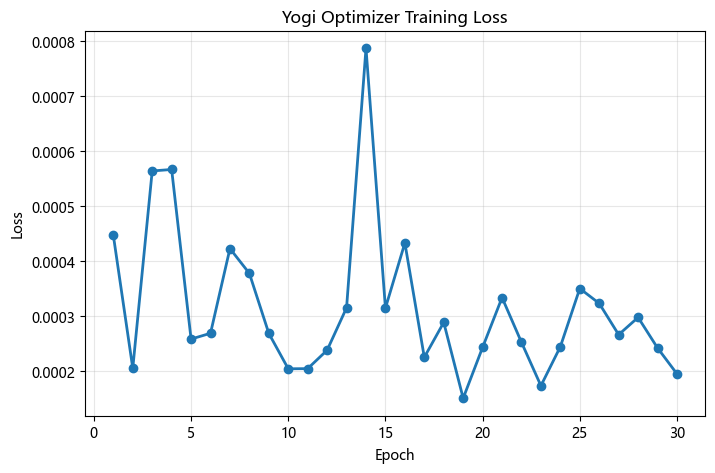

In [16]:
# 1. 生成数据
def get_data(batch_size=10, n_samples=1000, n_features=20):
    """生成线性回归数据"""
    X = torch.randn(n_samples, n_features)
    w_true = torch.randn(n_features, 1) * 0.01
    b_true = torch.randn(1) * 0.01
    y = X @ w_true + b_true + torch.randn(n_samples, 1) * 0.01

    dataset = TensorDataset(X, y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True), n_features

# 2. 初始化状态
def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

# 3. Yogi算法
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3

    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            # 更新一阶矩
            v[:] = beta1 * v + (1 - beta1) * p.grad

            # Yogi特有：二阶矩更新
            grad_sq = torch.square(p.grad)
            s[:] = s + (1 - beta2) * torch.sign(grad_sq - s) * grad_sq

            # 偏差校正
            v_hat = v / (1 - beta1 ** hyperparams['t'])
            s_hat = s / (1 - beta2 ** hyperparams['t'])

            # 参数更新
            p[:] -= hyperparams['lr'] * v_hat / (torch.sqrt(s_hat) + eps)
            p.grad.data.zero_()

    hyperparams['t'] += 1

# 4. 训练函数
def train():
    # 获取数据
    data_iter, feature_dim = get_data(batch_size=10)

    # 初始化参数
    w = torch.normal(0, 0.01, size=(feature_dim, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    params = [w, b]

    # 初始化状态和超参数
    states = init_adam_states(feature_dim)
    hyperparams = {'lr': 0.01, 't': 1}

    # 训练循环
    losses = []
    for epoch in range(30):  # 增加epoch以观察损失变化
        total_loss = 0
        batch_count = 0

        for X, y in data_iter:
            # 前向传播
            y_hat = X @ w + b
            loss = ((y_hat - y) ** 2 / 2).mean()

            # 反向传播
            loss.backward()

            # Yogi更新
            yogi(params, states, hyperparams)

            total_loss += loss.item()
            batch_count += 1

        avg_loss = total_loss / batch_count
        losses.append(avg_loss)
        print(f'Epoch {epoch+1}, Loss: {avg_loss:.6f}')

    return losses

# 5. 绘制损失曲线
def plot_loss(losses):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(losses) + 1), losses, marker='o', linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Yogi Optimizer Training Loss')
    plt.grid(True, alpha=0.3)
    plt.show()

# 6. 运行
losses = train()
plot_loss(losses)

## 学习率调度器：
### 基于训练进度的调度器（前述的学习率策略）
- 阶梯下降
- 指数衰减
- 余弦退火
- 线性衰减
### 基于性能指标的调度器
- 指标停止时降低学习率
- 循环调整学习率
### 预热调度器
- 预热就是为了防止在训练初期学习率太大（一开始就大的话，训练可能振荡，梯度爆炸，收敛到不好的局部最优等，预热就是缓慢增加到目标值一开始）。
- 线性预热：就是预热的时候学习率线性增加到目标值。
- 预先预热：就是按照余弦函数来增加。
| 特性 | 线性预热 | 余弦预热 |
|------|----------|----------|
| 变化曲线 | 直线 | 余弦曲线（凸函数） |
| 增长率 | 恒定 | 先快后慢 |
| 平滑性 | 有拐点 | 完全平滑 |
| 计算复杂度 | $O(1)$ | $O(1)$ |
| 公式 | $\text{lr} = \text{init} + (\text{base}-\text{init}) \times t/T$ | $\text{lr} = \text{init} + 0.5 \times (\text{base}-\text{init}) \times (1 - \cos(\pi \times t/T))$ |